<h1>COSIpy with continuum response</h1>

In [1]:
from COSIpy import *
import response
from fit import fit
plt.style.use('thomas')

Welcome to JupyROOT 6.22/02


/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
plt.style.use('thomas')

<h3>Data set (simulation): flat spectrum between 200 and 3000 keV at ~zenith without background:<br><br>
$S(E) = 1.18 \times 10^{-5} E^0\,\mathrm{ph\,s^{-1}\,cm^{-2}\,keV^{-1}}$</h3>

In [3]:
data_dir = '/Users/thomassiegert/data/COSI/Simulations/Crab/'
filename1 = 'FlatSource_001_CE0000-5000keV.tra.gz'

<h3>COSIpy work flow:</h3>

In [4]:
# create analysis object
analysis1 = COSIpy(data_dir,filename1)

In [5]:
# read in data (tra file)
analysis1.read_COSI_DataSet()

In [6]:
# define time binning, here 2 hours (24 hours in data set, i.e. 12 time bins)
Delta_T = 7200
analysis1.dataset.time_binning_tags(time_bin_size=Delta_T)

In [7]:
# definition of energy bins (exactly as response right now)
energy_bin_edges=np.array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450])#, 5000])

In [8]:
energy_bin_edges

array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450])

In [9]:
# define energy and pixel binning
pixel_size = 6.
analysis1.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                               pixel_size=pixel_size)

In [10]:
# bin data
analysis1.dataset.get_binned_data()

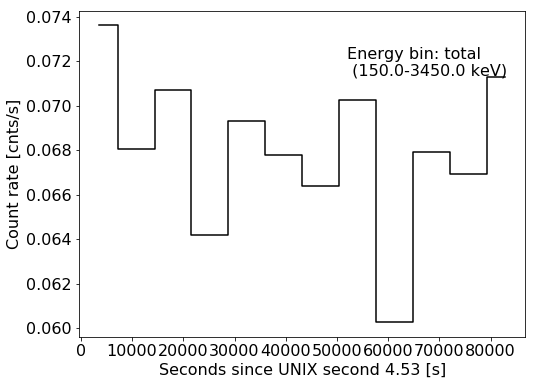

In [11]:
# light curve
analysis1.dataset.plot_lightcurve()

In [12]:
# definition of poitings (balloon stability + Earth rotation)
pointing1 = Pointing(dataset=analysis1.dataset,)

Text(0, 0.5, 'Zenith [deg]')

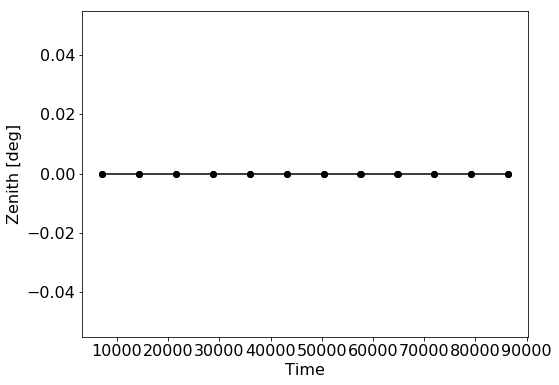

In [13]:
plt.plot(pointing1.cdtpoins,pointing1.zpoins[:,1],'o-')
plt.xlabel('Time')
plt.ylabel('Zenith [deg]')

In [14]:
# background
background1 = BG(dataset=analysis1.dataset,mode='default 6deg')

Reading in flight-average background response for 6 deg CDS binning ...


In [15]:
# source position definition
l1,b1 = 184.56-360,-5.78

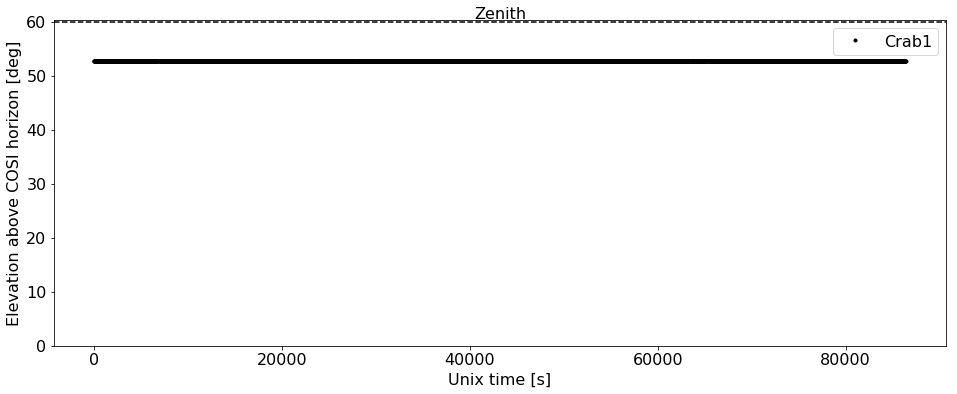

In [16]:
# plot elevation
analysis1.plot_elevation([l1],[b1],['Crab1'])

In [17]:
%load_ext autoreload

In [18]:
%aimport response

In [19]:
%autoreload 1

In [20]:
%aimport

Modules to reload:
response

Modules to skip:



<h3>Reading in response (quite large, though)</h3>

In [21]:
rsp = response.SkyResponse(filename='response/RegularResponseGrid_Continuum_10bins_v1.npz',pixel_size=6)

<h3>Calculate response for a point source at the known position</h3>

In [22]:
rsp.calculate_PS_response(analysis1.dataset,
                          pointing1,l1,b1,1,
                          background=background1,
                          pixel_size=pixel_size)

<h3>Fit to data to extract counts per unit time and energy:</h3>

In [23]:
result1 = fit(analysis1.dataset,
              pointing1,
              rsp,
              background1,
              priors=np.array([[0,1e8],[0,0.00001]]), # sky unconstrained, BG ~ 0
              verbose=True)

result1.MAP_solution()

Start optimising energy bin 1/9...

Energy range: 150-220 keV ...
Start optimising energy bin 2/9...

Energy range: 220-325 keV ...
Start optimising energy bin 3/9...

Energy range: 325-480 keV ...
Start optimising energy bin 4/9...

Energy range: 480-520 keV ...
Start optimising energy bin 5/9...

Energy range: 520-765 keV ...
Start optimising energy bin 6/9...

Energy range: 765-1120 keV ...
Start optimising energy bin 7/9...

Energy range: 1120-1650 keV ...
Start optimising energy bin 8/9...

Energy range: 1650-2350 keV ...
Start optimising energy bin 9/9...

Energy range: 2350-3450 keV ...

Initial log joint probability = -5e+09
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       8      -133.845   0.000138851   6.45035e-06           1           1       25   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5e+09
    Iter      log prob        ||dx|

<h3>Reading in "sky-only" simulation to compare extraction:</h3>

In [24]:
sky_filename1 = filename1
sky_data1 = COSIpy(data_dir,sky_filename1)
sky_data1.read_COSI_DataSet()
sky_data1.dataset.time_binning_tags(time_bin_size=1e5) # everything in one time bin
sky_data1.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=6.)
sky_data1.dataset.get_binned_data()

In [25]:
# pure sky count rate
sim_sky_rate1 = np.sum(sky_data1.dataset.binned_data,axis=(0,2,3))/(sky_data1.dataset.energies.energy_bin_wid*2*Delta_T)

In [26]:
n_e = analysis1.dataset.energies.n_energy_bins

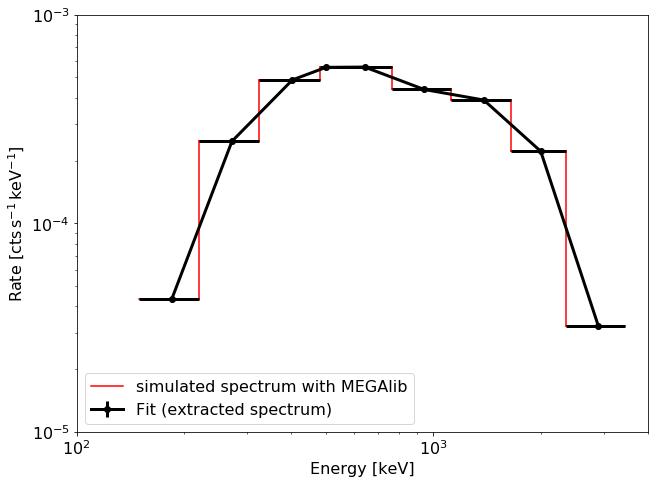

In [27]:
plt.figure(figsize=(10.24,7.68))

# fit
plt.errorbar(sky_data1.dataset.energies.energy_bin_cen,
             result1.diff_flux_map/Delta_T,
             xerr=sky_data1.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,n_e),fmt='o-',label='Fit (extracted spectrum)',
             zorder=10,linewidth=3)

# simulation
for i in range(n_e-1):
    plt.plot([sky_data1.dataset.energies.energy_bin_min[i],sky_data1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate1[i],2),'r-')
    if ((i >= 0) & (i<n_e-1)):
        plt.plot(np.repeat(sky_data1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate1[i],sim_sky_rate1[i+1]],'r-')
plt.plot([sky_data1.dataset.energies.energy_bin_max[-2],
              sky_data1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate1[-1],2),'r-',label='simulated spectrum with MEGAlib')   


plt.xlabel('Energy [keV]')
plt.ylabel(r'Rate [$\mathrm{cts\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,4000)
plt.ylim(1e-5,1e-3)

plt.legend()

<h3>Perfect fit (by definition).<br><br>
    Now estimating error bars:</h3>

In [28]:
result1.fit(iters=1000,pars=['Abg','flux','model_values','model_sky','model_bg','model_tot'])

###################################################################

Start fitting energy bin 1/9...

Energy range: 150-220 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 1/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  23.12    0.25   4.53  15.44  19.97  22.49   26.3  33.12    337    1.0
Abg[1]  7.6e-6  3.5e-7 6.0e-6 4.1e-7 2.9e-6 5.9e-6 1.1e-5 2.1e-5    291    1.0

Samples were drawn using NUTS at Tue Dec  1 14:15:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/9...

Energy range: 220-325 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 2/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 187.88    1.01  13.69 163.31 177.45 187.79 197.45 215.92    185    1.0
Abg[1]  8.2e-6  3.0e-7 5.7e-6 6.1e-7 3.8e-6 7.1e-6 1.1e-5 2.2e-5    364    1.0

Samples were drawn using NUTS at Tue Dec  1 14:16:17 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 3/9...

Energy range: 325-480 keV ...
Summary for energy bin 3/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 541.57    1.64  21.94 497.28 526.66 541.58 557.36 583.36    180    1.0
Abg[1]  8.0e-6  3.5e-7 6.2e-6 4.7e-7 3.7e-6 6.5e-6 1.1e-5 2.3e-5    318    1.0

Samples were drawn using NUTS at Tue Dec  1 14:16:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 4/9...

Energy range: 480-520 keV ...


Summary for energy bin 4/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 161.76    1.17  13.49 137.43  151.7 160.55 171.16 188.27    133    1.0
Abg[1]  8.1e-6  4.0e-7 6.1e-6 1.0e-7 3.0e-6 7.0e-6 1.2e-5 2.3e-5    236    1.0

Samples were drawn using NUTS at Tue Dec  1 14:16:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 5/9...

Energy range: 520-765 keV ...
Summary for energy bin 5/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 989.31    1.73  31.57 926.88 966.99 991.74 1010.7 1050.6    331    1.0
Abg[1]  7.8e-6  4.0e-7 6.0e-6 2.8e-7 3.2e-6 6.2e-6 1.1e-5 2.2e-5    224   1.02

Samples were drawn using NUTS at Tue Dec  1 14:17:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 6/9...

Energy range: 765-1120 keV ...
Summary for energy bin 6/9:



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 1119.2    2.03   33.5 1058.2 1096.9 1116.8 1143.2 1189.9    272    1.0
Abg[1]  7.5e-6  4.3e-7 6.3e-6 1.5e-7 2.3e-6 6.2e-6 1.1e-5 2.2e-5    213    1.0

Samples were drawn using NUTS at Tue Dec  1 14:17:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 7/9...

Energy range: 1120-1650 keV ...
Summary for energy bin 7/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 8/9...

Energy range: 1650-2350 keV ...
Summary for energy bin 8/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 1117.9    2.05  32.75 1053.7 1095.9 1115.4 1138.5 1191.5    255    1.0
Abg[1]  7.7e-6  3.2e-7 5.6e-6 6.0e-7 3.5e-6 6.5e-6 1.1e-5 2.1e-5    303   1.01

Samples were drawn using NUTS at Tue Dec  1 14:19:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 9/9...

Energy range: 2350-3450 keV ...
Summary for energy bin 9/9:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 256.71    1.07  15.24 229.24 246.08 255.41 266.46 289.54    204    1.0
Abg[1]  8.4e-6  2.9e-7 5.6e-6 7.0e-7 4.0e-6 7.6e-6 1.2e-5 2.1e-5    385    1.0

Samples were drawn using NUTS at Tue Dec  1 14:20:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################


Gradient evaluation took 0.001199 seconds
1000 transi

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[544] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[544] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



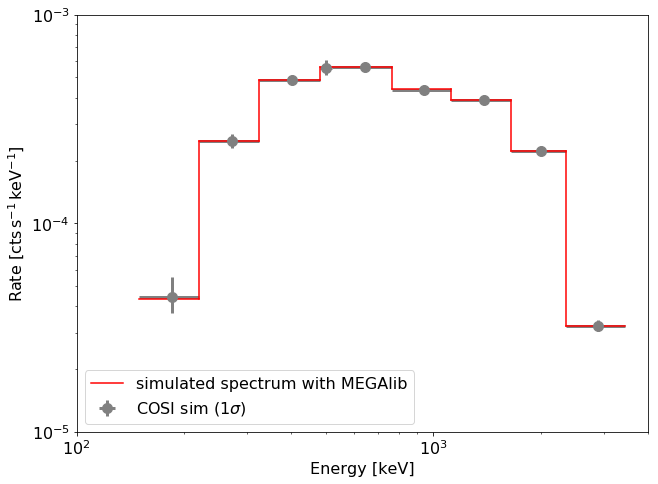

In [29]:
plt.figure(figsize=(10.24,7.68))

# data
plt.errorbar(analysis1.dataset.energies.energy_bin_cen[0:9],
             result1.diff_flux[0:9]/Delta_T,
             xerr=analysis1.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result1.diff_flux_err[0:9,:].T)/Delta_T,
             fmt='o',linewidth=3,color='gray',markersize=10,
             label=r'COSI sim ($1\sigma$)')


# simulation
for i in range(n_e-1):
    plt.plot([sky_data1.dataset.energies.energy_bin_min[i],sky_data1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate1[i],2),'r-')
    if ((i >= 0) & (i<n_e-1)):
        plt.plot(np.repeat(sky_data1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate1[i],sim_sky_rate1[i+1]],'r-')
plt.plot([sky_data1.dataset.energies.energy_bin_max[-2],
              sky_data1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate1[-1],2),'r-',label='simulated spectrum with MEGAlib')  


plt.xlabel('Energy [keV]')
plt.ylabel(r'Rate [$\mathrm{cts\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(100,4000)
plt.ylim(1e-5,1e-3)

plt.legend()

<h3>How to fit this count rate spectrum to get spectral parameter in physical (model) space: (cf. presentation)</h3>

<h3>Definition of smooth functions (e.g. powerlaw):</h3>

In [61]:
def powerlaw(energy, p):
    """
    Returns:
    Differential flux shaped as power-law function "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (in ph/cm2/s/keV)
    :param p:      p[1] = Power-law index (unitless)

    Misc:
    E0             Pivotal energy, i.e. where the power-law is normalised at (in keV)
    """
    
    E0 = 100.
    
    return p[0]*np.power(energy/E0,p[1])

In [66]:
def powerlaw_boxcar(energy, p):
    """
    Returns:
    Differential flux shaped as power-law function "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (in ph/cm2/s/keV)
    :param p:      p[1] = Power-law index (unitless)
    :param p:      p[2] = Lower energy bound
    :param p:      p[3] = Higher energy bound

    Misc:
    E0             Pivotal energy, i.e. where the power-law is normalised at (in keV)
    """
    
    E0 = 100.

    return p[0]*np.power(energy/E0,p[1])*np.heaviside(energy-p[2],0)*np.heaviside(p[3]-energy,0)

<h3>Numerical integration of smooth functions to get number of photons:</h3>

In [30]:
def integrate_powerlaw(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(powerlaw(e_lo,p)+4*powerlaw((e_hi+e_lo)/2.0,p)+powerlaw(e_hi,p))

# same doesn't work for boxcar version because edge can be anywhere
def integrate_powerlaw_boxcar(e_lo,e_hi,p):
    # loop over bins to check boundaries e_lo ~ p[2] and e_hi ~ p[3]
    n_e = len(e_lo)
    val = np.zeros(n_e)
    for i in range(n_e):
        if ((p[2] <= e_lo[i]) & (p[3] >= e_hi[i])):
            #print('1',i)
            val[i] = (e_hi[i]-e_lo[i])/6.0*(powerlaw(e_lo[i],p[0:2])+4*powerlaw((e_hi[i]+e_lo[i])/2.0,p[0:2])+powerlaw(e_hi[i],p[0:2]))
        elif ((p[2] > e_lo[i]) & (p[3] >= e_hi[i])):
            #print('2',i)
            val[i] = (e_hi[i]-p[2])/6.0*(powerlaw(p[2],p[0:2])+4*powerlaw((e_hi[i]+p[2])/2.0,p[0:2])+powerlaw(e_hi[i],p[0:2]))
        elif ((p[3] < e_hi[i]) & (p[2] <= e_lo[i]) & ~(p[3] < e_lo[i])):
            #print('3',i)
            val[i] = (p[3]-e_lo[i])/6.0*(powerlaw(e_lo[i],p[0:2])+4*powerlaw((p[3]+e_lo[i])/2.0,p[0:2])+powerlaw(p[3],p[0:2]))
        else:
            #print('4',i)
            val[i] = 0.
    return val

<h3>$\mathrm{ph\,s^{-1}\,cm^{-2}\,keV^{-1}} \Rightarrow \mathrm{ph\,s^{-1}\,cm^{-2}}$:</h3>

In [32]:
from spectral_shapes import *

In [33]:
# dN
plaw_true_fluxes = integrate_powerlaw(rsp.e_min, rsp.e_max, (1.18e-5,0))
plaw_boxcar_true_fluxes = integrate_powerlaw_boxcar(rsp.e_min, rsp.e_max, (1.18e-5,0,200,3000)) 

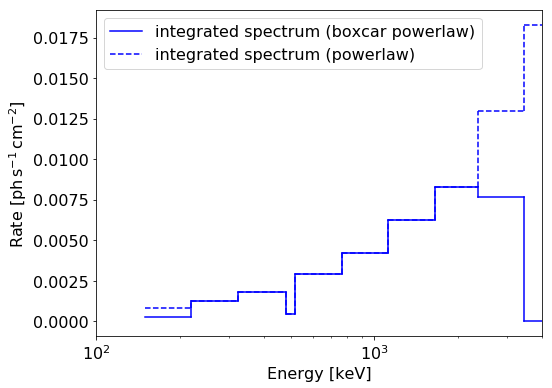

In [34]:
# integrated flux boxcar 
for i in range(n_e):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_boxcar_true_fluxes[i],2),'b-')
    if ((i >= 0) & (i<n_e)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_boxcar_true_fluxes[i],plaw_boxcar_true_fluxes[i+1]],'b-')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(plaw_boxcar_true_fluxes[-1],2),'b-',label='integrated spectrum (boxcar powerlaw)')  


# integrated flux boxcar 
for i in range(n_e):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_true_fluxes[i],2),'b--')
    if ((i >= 0) & (i<n_e)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_true_fluxes[i],plaw_true_fluxes[i+1]],'b--')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(plaw_true_fluxes[-1],2),'b--',label='integrated spectrum (powerlaw)')  


plt.xlabel('Energy [keV]')
plt.ylabel(r'Rate [$\mathrm{ph\,s^{-1}\,cm^{-2}}$]')
plt.xscale('log')
plt.xlim(100,4000)
plt.legend()

<h3>The step $\mathrm{ph\,s^{-1}\,cm^{-2}} \Rightarrow \mathrm{ph\,s^{-1}}$ requires the effective area tand the energy redistribution matrix.<br>
The matrix has to be averaged over the course of the data set:</h3>

In [35]:
# zenith and azimuth of each pointing (will happen internally)
zens1,azis1 = response.zenazi(pointing1.xpoins[:,0],pointing1.xpoins[:,1],
                              pointing1.ypoins[:,0],pointing1.ypoins[:,1],
                              pointing1.zpoins[:,0],pointing1.zpoins[:,1],
                              l1,b1)

# zenith indices of response
zidx = np.ceil(zens1/pixel_size).astype(int)
# azimuth indices of response
aidx = np.ceil(azis1/pixel_size).astype(int)

In [36]:
# energy normalisation matrix (???)
erg_mat = np.meshgrid(rsp.e_wid,rsp.e_wid)

In [37]:
# weighting the response at each pointing
avg_response = 0

for n in tqdm(range(len(pointing1.dtpoins))):
    avg_response += rsp.rsp.response_grid_normed[zidx[n],aidx[n],:,:,0:,0:].T/erg_mat[0][0:,0:,None,None]*pointing1.dtpoins[n]

rmf = np.sum(avg_response,axis=(2,3))

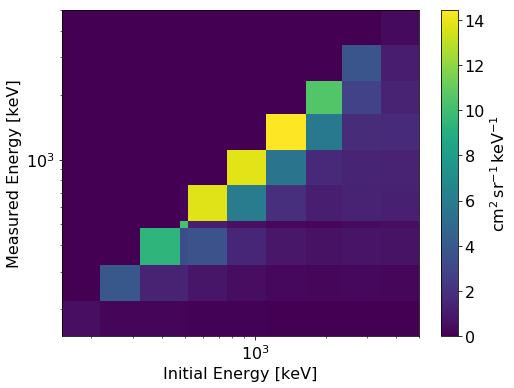

In [38]:
plt.pcolormesh(rsp.e_edges[0:],rsp.e_edges[0:],rmf)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Initial Energy [keV]')
plt.ylabel('Measured Energy [keV]')
plt.colorbar(label='$\mathrm{cm^{2}\,sr^{-1}\,keV^{-1}}$')

<h3>$\mathrm{ph\,s^{-1}\,cm^{-2}} \Rightarrow \mathrm{ph\,s^{-1}}$:<br><br>
$\int\,dE_{f}\,\mathrm{RMF}(E_f,E_i)S(E_i,\vec{\alpha}) \Longrightarrow$ Dot product.</h3>

In [39]:
plaw_boxcar_folded_counts = np.dot(rmf,plaw_boxcar_true_fluxes[0:])
plaw_folded_counts = np.dot(rmf,plaw_true_fluxes[0:])

In [40]:
# normalisation to energy (units of time included in the spectral model ??)
plaw_boxcar_folded_count_rate = plaw_boxcar_folded_counts/(rsp.e_wid[0:])
plaw_folded_count_rate = plaw_folded_counts/(rsp.e_wid[0:])

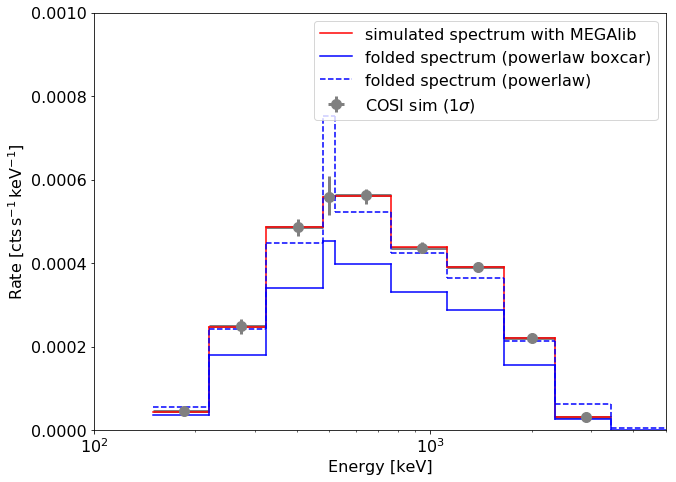

In [41]:
plt.figure(figsize=(10.24,7.68))

# data
plt.errorbar(analysis1.dataset.energies.energy_bin_cen[0:9],
             result1.diff_flux[0:9]/Delta_T,
             xerr=analysis1.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result1.diff_flux_err[0:9,:].T)/Delta_T,
             fmt='o',linewidth=3,color='gray',markersize=10,
             label=r'COSI sim ($1\sigma$)')


# simulation
for i in range(n_e-1):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(sim_sky_rate1[i],2),'r-')
    if ((i >= 0) & (i<n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [sim_sky_rate1[i],sim_sky_rate1[i+1]],'r-')
plt.plot([rsp.e_max[-3],
              rsp.e_max[-2]],
             np.repeat(sim_sky_rate1[-1],2),'r-',label='simulated spectrum with MEGAlib')  


# folded spectrum powerlaw boxcar
for i in range(n_e):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_boxcar_folded_count_rate[i],2),'b-')
    if ((i >= 0) & (i<n_e)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_boxcar_folded_count_rate[i],plaw_boxcar_folded_count_rate[i+1]],'b-')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(plaw_boxcar_folded_count_rate[-1],2),'b-',label='folded spectrum (powerlaw boxcar)')  

# folded spectrum powerlaw
for i in range(n_e):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_folded_count_rate[i],2),'b--')
    if ((i >= 0) & (i<n_e)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_count_rate[i],plaw_folded_count_rate[i+1]],'b--')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(plaw_folded_count_rate[-1],2),'b--',label='folded spectrum (powerlaw)')  


plt.xlabel('Energy [keV]')
plt.ylabel(r'Rate [$\mathrm{cts\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(100,5000)
plt.ylim(0,1e-3)

plt.legend()

In [42]:
plaw_boxcar_folded_count_rate[0:9]/(result1.diff_flux/Delta_T)

array([0.78853743, 0.72032831, 0.70112392, 0.81116883, 0.70829064,
       0.75454361, 0.73482596, 0.70205598, 0.80987518])

<h3>Looks almost correct? There is a factor of $1/0.75$ missing?<br>
    Is there a problem with the 511 keV bin?<br>
    The high-energy bin is too high (response "gauged" from 150 to 5000 keV? -- turns out the powerlaw edges are important...).</h3>

In [43]:
from spectral_shapes import *

<h1>Spectral fitting of extracted data with averaged RMF:</h1>

<h3>Model definition (everything from above at once); Definition of the likelihood:</h3>

In [44]:
def COSI_model_fit(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function, eval=False):
    """
    Returns:
    Negative normal-distributed log-likelihood for COSI data fitted with 
    arbitraty spectral model, accounting for the spectral response (default).
    Or, with eval=True, the output model in data space (in units of cnts/s/keV)
    
    Parameters:
    :param theta:     Array of to-be-fitted parameters used in combination with defined 'function'
    :param x:         Energy array (dim=(n,); in keV)
    :param y:         Differential count rate array (dim=(n,); in cnts/s/keV)
    :param dx:        Energy bin sizes for x (dim=(n,); in keV)
    :param y_err:     Uncertainties on differential count rate (one sigma values) (dim=(n,); in cnts/s/keV)
    :param rsp:       Response matrix that fits to the dimensions of x (and dx, y, y_err; dim=(m,n);, units cm2 something)
    :param e_lo:      Lower interpolated energy edges for response calculation(dim=(m,); in keV)
    :param e_hi:      Upper interpolated energy edges for response calculation(dim=(m,); in keV)  
    :param function:  String of named function 
    """
    # Now, same things as above:
    # Integrate model with Simpson's rule over the interpolated energy bins
    # this works in general for smooth models, but not for cuts and steps, etc.
    if function != 'powerlaw_boxcar':
        integrated_model = (e_hi-e_lo)/6.0*(globals()[function](e_lo,theta)+
                                            4*globals()[function]((e_lo+e_hi)/2.0,theta)+
                                            globals()[function](e_hi,theta))
    else:
        integrated_model = integrate_powerlaw_boxcar(e_lo,e_hi,theta)
        #print(np.sum(integrated_model))

    # Apply response matrix
    folded_model = np.dot(integrated_model,rsp)
 
    # Return to differential model
    folded_differential_model = folded_model / dx

    # Evaluate either chi2
    if eval==False:
        return -0.5*np.nansum((y-folded_differential_model)**2/y_err**2)
    # or return the folded model itself at a certain set of parameters
    else:
        return folded_differential_model

<h3>Including priors (optional)</h3>

In [45]:
# add prior for each parameter to be fitted according to definition in 'function'
def ln_prior_COSI_spectrum(theta,prior):
    """
    this function assumes prior dictionaries of the shape:
    prior = {0: ('normal_prior',1e-4,1e-5,'Amplitude'),
             1: ('uniform_prior',-1.8,-1.6,'Index')}
    with the key being numbered sequentially
    then there is a tag for the prior function (normal, uniform, whatever you define else)
    then the prior values as defined in the functions
    and a name to identifiy later
    NO CHECKS FOR CONSISTENCY ARE PERFORMED
    """
    lnprior = 0.
    for p in range(len(theta)):
        lnprior += globals()[prior[p][0]](theta[p],prior[p][1:])
    return lnprior

<h3>Combining likelihood and prior for full posterior:</h3>

In [46]:
def ln_posterior_COSI_spectrum(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function, prior):
    lp = ln_prior_COSI_spectrum(theta,prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + COSI_model_fit(theta, x, y, dx, y_err, rsp, e_lo, e_hi, function)

<h3>Selection of prior distribution:</h3>

In [179]:
from scipy.special import erf as erf

def normal_prior(par,p):
    mu = p[0]
    sigma = p[1]
    return -0.5*(par-mu)**2/sigma**2


def uniform_prior(par,p):
    lo = p[0]
    hi = p[1]
    if lo <= par <= hi:
        return 0.0
    return -np.inf


def truncated_normal_prior(par,p):
    mu = p[0]
    sigma = p[1]
    lo = p[2]
    hi = p[3]
    if lo <= par <= hi:
        return -0.5*(par-mu)**2/sigma**2 - np.log(sigma) - np.log(erf((hi-mu)/(np.sqrt(2)*sigma)) - erf((lo-mu)/(np.sqrt(2)*sigma)))
    return -np.inf

def loguniform_prior(par,p):
    lo = p[0]
    hi = p[1]
    if lo <= par <= hi:
        return 0.0
    return -np.inf

<h3>Now fitting (here, I use emcee, but would want to use Stan later):</h3>

In [125]:
# true parameters
params0 = [1.18e-5,   # power-law amplitude at 100 keV in ph/cm2/s/keV
           -0.001,       # power-law index
           200,       # lower energy bound
           3000]      # upper energy bound       

In [126]:
# include all spectral shapes
from priors import *
from spectral_shapes import *

In [127]:
# Same as above but in one step: "how does the data look like"
model0 = COSI_model_fit(params0,             # set of parameters
                        analysis1.dataset.energies.energy_bin_cen,0,analysis1.dataset.energies.energy_bin_wid*2,0,
                        # energy band definition (the zeros will be important later)
                        rmf[0:9,0:9].T,rsp.e_min[0:9],rsp.e_max[0:9],
                        # redistribution matrix definition
                        'powerlaw_boxcar',   # function to fit/evaluate
                        eval=True)           # evaluate function rather than fitting it (see comment about zeros)

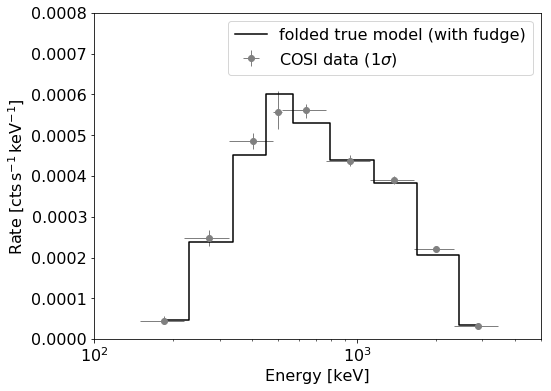

In [128]:
# same comparison as above with fudge factor
plt.errorbar(analysis1.dataset.energies.energy_bin_cen[0:9],
             result1.diff_flux[0:9]/Delta_T,
             xerr=analysis1.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result1.diff_flux_err[0:9,:].T)/Delta_T,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')
plt.step(rsp.e_cen[0:9],model0/0.75,where='mid',label='folded true model (with fudge)')
plt.xlabel('Energy [keV]')
plt.ylabel(r'Rate [$\mathrm{cts\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(100,5000)
plt.ylim(0,0.8e-3)
plt.legend()

<h3>Definition of priors (mainly to fix the bounds of the powerlaw):</h3>

In [129]:
prior0 = {0: ('truncated_normal_prior',1.18e-5/0.75,1e8,0,np.inf,r'$C_0$'),
          1: ('normal_prior',0.0,5.0,r'$\alpha$'),
          2: ('uniform_prior',199,211,r'$E_{lo}$'),
          3: ('uniform_prior',2985,3015,r'$E_{hi}$')}
function = 'powerlaw_boxcar'

In [130]:
init = np.array(params0)
init[0] = 1.18e-5/0.75
init_var = np.array(params0)*1e-4

In [131]:
import time
import emcee

In [148]:
ndim, nwalkers = len(prior0), 20
pos = [init + np.random.randn(ndim)*init_var for i in range(nwalkers)]

start = time.time()

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                ln_posterior_COSI_spectrum,
                                args=(analysis1.dataset.energies.energy_bin_cen,
                                      result1.diff_flux[0:9]/Delta_T,
                                      analysis1.dataset.energies.energy_bin_wid*2,
                                      np.abs(result1.diff_flux_err[0:9,:].T)/Delta_T,
                                      rmf[0:9,0:9].T,
                                      rsp.e_min[0:9],
                                      rsp.e_max[0:9],
                                      function,
                                      prior0))

_ = sampler.run_mcmc(pos, 10000, progress=True)
    
end = time.time()

ttime = end - start
print("Processing took {0:.1f} seconds".format(ttime))

100%|██████████| 10000/10000 [00:48<00:00, 211.85it/s]


Processing took 48.3 seconds


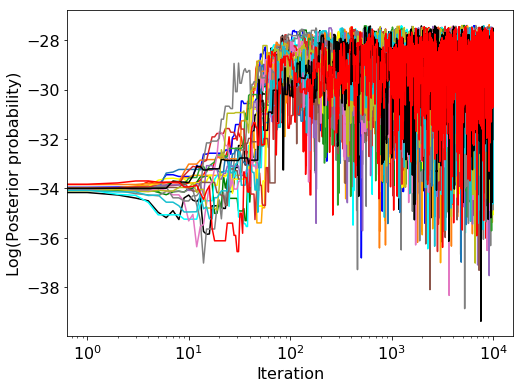

In [149]:
plt.plot(sampler.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')
plt.xscale('log')

In [150]:
scl = [1e5,1,1,1]

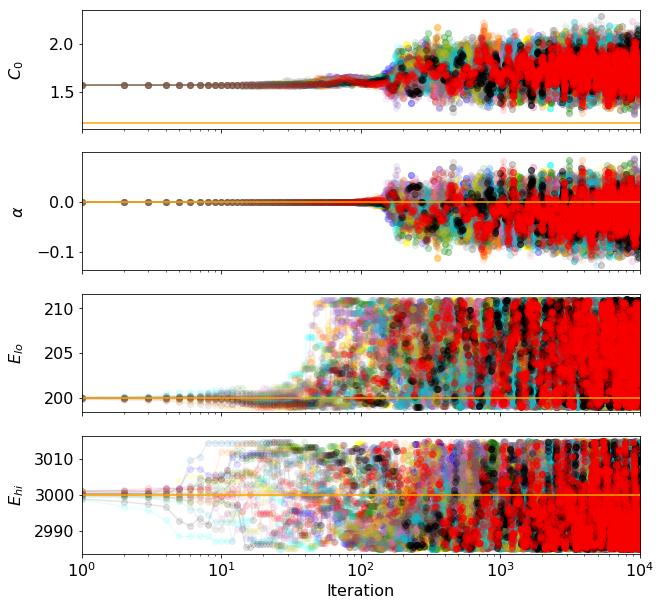

In [151]:
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2.5), sharex=True)
samples = sampler.get_chain()

labels = [prior0[i][-1] for i in range(len(prior0))]
truths = np.array(params0)*scl

for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples)),samples[:, :, i]*scl[i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samples))
    ax.plot([1,len(samples)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

In [152]:
burnin = 5000
import corner

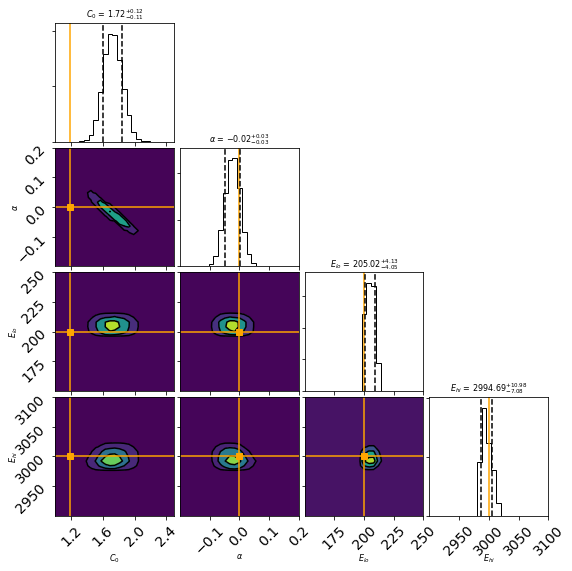

In [153]:
samplesf = sampler.flatchain
sigma = 68.3
fig = corner.corner(samplesf[burnin*nwalkers:,:]*scl,
                    labels=labels,
                    truths=np.array(params0)*scl,
                    quantiles=(50+sigma/np.array([-2,+2]))/100.,
                    show_titles=True,
                    bins=25,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.viridis, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    range=[(1.0,2.5),(-0.2,0.2),(150,250),(2900,3100)],
                    #       (-1.3,-0.8),(0.6,1.6),(-2.6,-1.5),
                    #       (40,65),(0,3),(0,6),
                    #       (2,2.5),(0,30),(0,5)],
                    truth_color='orange',
                    label_kwargs={"fontsize": 8},
                    max_n_ticks=4,
                    title_kwargs={"fontsize": 8})
for ax in fig.get_axes():
      #ax.tick_params(axis='both', which='major', labelsize=14)
      #ax.tick_params(axis='both', which='minor', labelsize=12)    
      ax.tick_params(axis='both', labelsize=14)
fig.set_size_inches(8,8)

#plt.savefig('corner_plot_spectral_fit.pdf')

In [154]:
# how many samples
# data space
n_samples = nwalkers*100#samplesf.shape[0]
y_models = np.zeros((len(result1.diff_flux[0:9]),n_samples))

# where to evaluate model
x_model = np.logspace(np.log10(100),np.log10(5000),1000)
N_model = len(x_model)

y_modelsm = np.zeros((N_model,n_samples))
y_modelsm_cont = np.zeros((N_model,n_samples))
y_modelsm_line = np.zeros((N_model,n_samples))

for i in tqdm(range(nwalkers*9900,nwalkers*9900+n_samples)):
    i -= nwalkers*9900
    y_models[:,i] = COSI_model_fit(samplesf[i,:],
                                   analysis1.dataset.energies.energy_bin_cen,0,
                                   analysis1.dataset.energies.energy_bin_wid*2,0,
                                   rmf[0:9,0:9].T,rsp.e_min[0:9],rsp.e_max[0:9],
                                   'powerlaw_boxcar',          # function to fit/evaluate
                                    eval=True) 
    
    y_modelsm[:,i] = globals()[function](x_model,samplesf[i,:])

In [159]:
np.mean(samplesf[190000:,0]),np.std(samplesf[190000:,0])

(1.724574897695034e-05, 1.2543485823892454e-06)

In [160]:
np.mean(samplesf[190000:,1]),np.std(samplesf[190000:,1])

(-0.022915956449242658, 0.027697166402130834)

In [161]:
params0

[1.18e-05, -0.001, 200, 3000]

In [162]:
np.mean(samplesf[190000:,0])/params0[0]

1.4615041505890118

In [163]:
ee = analysis1.dataset.energies.energy_bin_cen
ee_err = analysis1.dataset.energies.energy_bin_wid

In [164]:
level = 95.4
tot_model95_lo = np.percentile(y_modelsm[:,::2], 50 - 0.5*level, axis=1 )
tot_model95_hi = np.percentile(y_modelsm[:,::2], 50 + 0.5*level, axis=1 )

level = 68.3
tot_model68_lo = np.percentile(y_modelsm[:,::2], 50 - 0.5*level, axis=1 )
tot_model68_hi = np.percentile(y_modelsm[:,::2], 50 + 0.5*level, axis=1 )

level = 0
tot_model_median = np.percentile(y_modelsm[:,::2], 50 - 0.5*level, axis=1 )


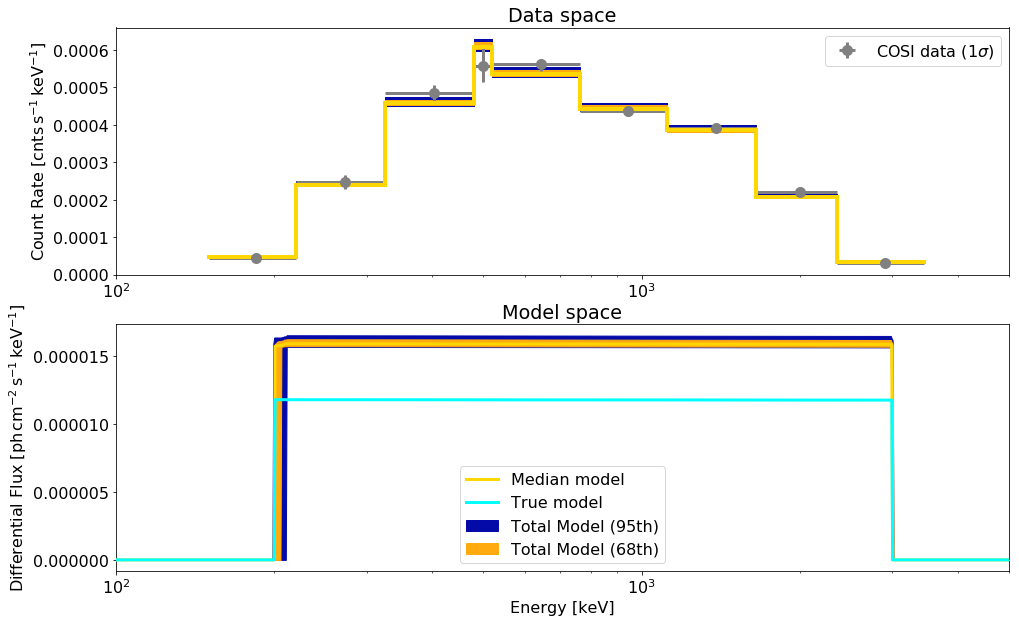

In [168]:
fix, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,10))

ax[0].errorbar(analysis1.dataset.energies.energy_bin_cen[0:9],
             result1.diff_flux[0:9]/Delta_T,
             xerr=analysis1.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result1.diff_flux_err[0:9,:].T)/Delta_T,
             fmt='o',linewidth=3,color='gray',markersize=10,
             label=r'COSI data ($1\sigma$)')

tot_fit_model = np.median(y_models[:,:],axis=1)

for i in range(len(ee)):
    level = 95.4
    ax[0].fill_between([ee[i]-ee_err[i],ee[i]+ee_err[i]],
                    np.repeat(np.percentile(y_models[i,:], 50 - 0.5*level),2),
                    np.repeat(np.percentile(y_models[i,:], 50 + 0.5*level),2),
                    color='xkcd:cobalt blue',alpha=1.0,step='mid')
    
    level = 68.3
    ax[0].fill_between([ee[i]-ee_err[i],ee[i]+ee_err[i]],
                    np.repeat(np.percentile(y_models[i,:], 50 - 0.5*level),2),
                    np.repeat(np.percentile(y_models[i,:], 50 + 0.5*level),2),
                    color='xkcd:yellowish orange',alpha=1,step='mid')


    ax[0].plot([ee[i]-ee_err[i],ee[i]+ee_err[i]],
             np.repeat(tot_fit_model[i],2),
             linewidth=4,color='gold')
    if i != len(ee)-1:
        ax[0].plot([ee[i]+ee_err[i],ee[i+1]-ee_err[i+1]],
                 [tot_fit_model[i],tot_fit_model[i+1]],
                 linewidth=4,color='gold')
    
ax[0].set_xlabel('')
ax[0].set_ylabel(r'Count Rate [$\mathrm{cnts\,s^{-1}\,keV^{-1}}$]')

ax[0].set_xscale('log')
#ax[0].set_yscale('log')

ax[0].set_xlim(100,5000)
#ax[0].set_ylim(5e-2,5e0)

ax[0].set_title('Data space')
ax[0].legend()



ax[1].fill_between(x_model,
                tot_model95_lo,
                tot_model95_hi,
                color='xkcd:cobalt blue',alpha=1.0,label='Total Model (95th)',zorder=1000)

ax[1].fill_between(x_model,
                tot_model68_lo,
                tot_model68_hi,
                color='xkcd:yellowish orange',alpha=1.0,label='Total Model (68th)',zorder=1000)

true_model = powerlaw_boxcar(x_model,params0)

ax[1].plot(x_model,tot_model_median,color='gold',linewidth=3,zorder=1000,label='Median model')
ax[1].plot(x_model,true_model,color='cyan',linewidth=3,zorder=1000,label='True model')

ax[1].set_xlabel('Energy [keV]')
ax[1].set_ylabel(r'Differential Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax[1].set_title('Model space')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_xlim(100,5000)
#ax[1].ylim(1e-8,1e-3)

ax[1].legend()

In [832]:
np.mean(np.sum(rsp.e_wid[0:8]/crab_folded_counts4)/np.sum(1/crab_folded_counts4)/domega1[good_poins])

35887.97470216064

In [696]:
crab_folded_counts1 = 0
crab_folded_counts2 = 0
crab_folded_counts3 = 0

for i in tqdm(range(30)):
    for j in range(1145):
        crab_folded_counts1 += np.dot(rsp.rsp.response_grid_normed[1,8,i,j,0:8,0:8].T/erg_mat[0][0:8,0:8],crab_true_fluxes[0:8])*Delta_T#*domega1
        #crab_folded_counts2 += np.dot(crab_true_fluxes[0:8],rsp.rsp.response_grid_normed[1,8,i,j,0:8,0:8]/erg_mat[1])*Delta_T*domega1
        crab_folded_counts2 += np.dot(rsp.rsp.response_grid_normed[5,13,i,j,0:8,0:8].T/(erg_mat[0][0:8,0:8]),crab_true_fluxes[0:8])*Delta_T#*domega2
        crab_folded_counts3 += np.dot(rsp.rsp.response_grid_normed[8,14,i,j,0:8,0:8].T/(erg_mat[0][0:8,0:8]),crab_true_fluxes[0:8])*Delta_T#*domega3
#crab_folded_counts1 *= rsp.e_wid[0:8]**2

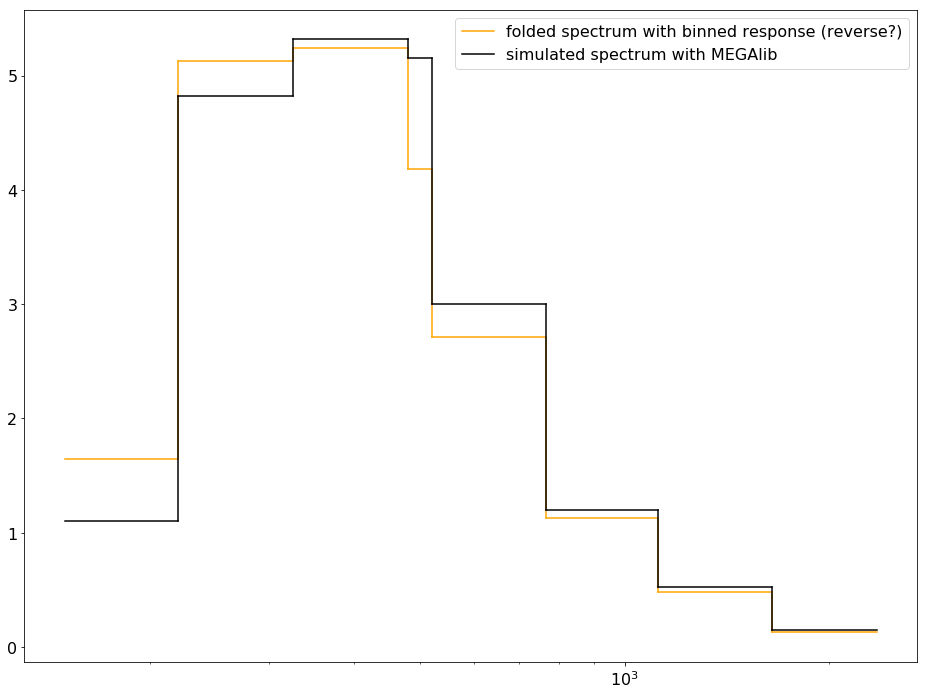

In [697]:
plt.figure(figsize=(16,12))

off = -2

fac = 8500#11309.7#12345#86400*8#/2.2#6**2#86400/0.01087097#10000000#sky_data1.dataset.times.times_wid

    
for i in range(rsp.n_e-1+off):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(crab_folded_counts1[i]/rsp.e_wid[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1+off)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [crab_folded_counts1[i]/rsp.e_wid[i]*fac,
                  crab_folded_counts1[i+1]/rsp.e_wid[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2+off],
              rsp.e_max[-1+off]],
             np.repeat(crab_folded_counts1[-1]/rsp.e_wid[-1+off]*fac,2),'-',color='orange',label='folded spectrum with binned response (reverse?)')

    
sim_crab_ate1 = np.sum(crab_data1.dataset.binned_data,axis=(0,2,3))/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_crab_ate1[i],2),'k-')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_crab_ate1[i],
                  sim_crab_ate1[i+1]],'k-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_crab_ate1[-1],2),'k-',label='simulated spectrum with MEGAlib')   

#plt.ylim(0,2200)
plt.xscale('log')
plt.legend()

IndexError: index 8 is out of bounds for axis 0 with size 8

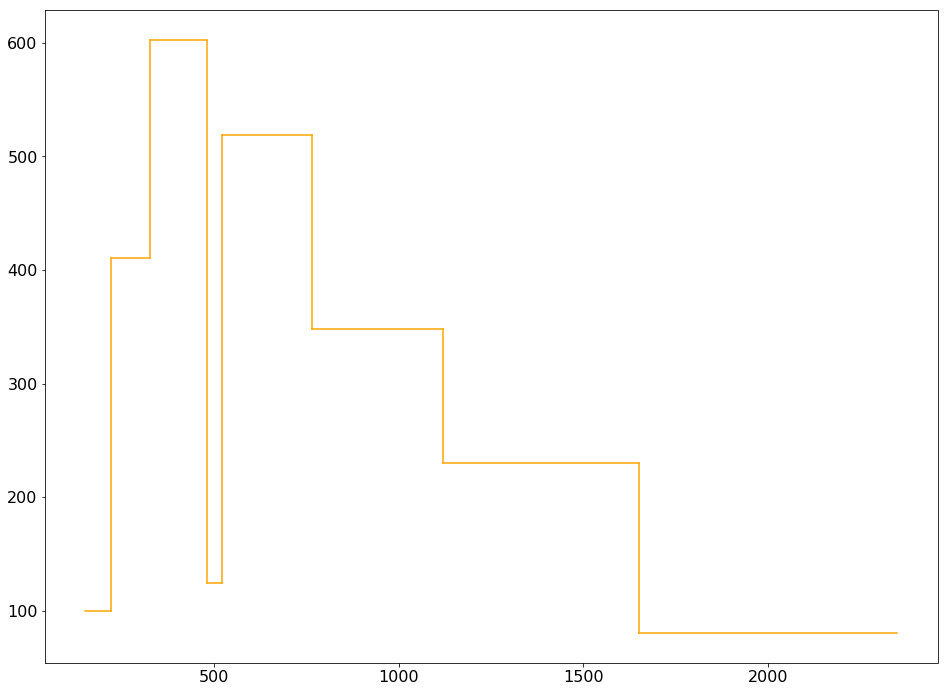

In [698]:
plt.figure(figsize=(16,12))

fac = 8500#86400*8#/2.2#6**2#86400/0.01087097#10000000#sky_data1.dataset.times.times_wid

    
for i in range(rsp.n_e-1):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(crab_folded_counts2[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [crab_folded_counts2[i]*fac,
                  crab_folded_counts2[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(crab_folded_counts2[-1]*fac,2),'-',color='orange',label='folded spectrum with binned response (reverse?)')

    
sim_crab_rate2 = np.sum(crab_data2.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_crab_rate2[i],2),'k-')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_crab_rate2[i],
                  sim_crab_rate2[i+1]],'k-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_crab_rate2[-1],2),'k-',label='simulated spectrum with MEGAlib')   

plt.ylim(0,1200)
plt.xscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(16,12))

fac = 8500#86400*8#/2.2#6**2#86400/0.01087097#10000000#sky_data1.dataset.times.times_wid

    
for i in range(rsp.n_e-1):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(crab_folded_counts3[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [crab_folded_counts3[i]*fac,
                  crab_folded_counts3[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(crab_folded_counts3[-1]*fac,2),'-',color='orange',label='folded spectrum with binned response (reverse?)')

    
sim_crab_rate3 = np.sum(crab_data3.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_crab_rate3[i],2),'k-')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_crab_rate3[i],
                  sim_crab_rate3[i+1]],'k-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_crab_rate3[-1],2),'k-',label='simulated spectrum with MEGAlib')   

plt.ylim(0,1200)
plt.xscale('log')
plt.legend()

In [ ]:
response.get_response_with_weights(rsp.rsp.response_grid_normed,zens,azis,binsize=6)

In [ ]:
widx = response.get_response_weights_vector(zens,azis,6,cut=60)

In [ ]:
pointing.cdtpoins

In [ ]:
(widx[0][0,0,:] < 0).shape

In [ ]:
widx[0][]

In [ ]:
widx[1][widx[0][:,0,:] < 0] = 0.
widx[1][widx[0][:,1,:] < 0] = 0.
for i in range(4):
    widx[0][i,0,widx[0][i,0,:] < 0] = 0.
    widx[0][i,1,widx[0][i,1,:] < 0] = 0.

In [ ]:
widx

In [ ]:
widx[1][widx[0][:,0,:] < 0] = 0.
widx[1][widx[0][:,1,:] < 0] = 0.

In [ ]:
plt.plot(pointing.cdtpoins,widx[0][0,1,:])

In [842]:
(1465734728.8456015587-1465371470.1073491573)/86400

4.204383544587978

In [ ]:
    for i in range(2):
        widx[i][widx[i] < 0] = 0.

In [ ]:
widx[1][3,:]

In [ ]:
rsp.rsp.response_grid_normed.shape

In [44]:
from fit import fit

In [721]:
rsp.calculate_PS_response(analysis1.dataset,
                          pointing1,l1,b1,1e0,
                          background=background1,
                          pixel_size=6.)
result1 = fit(analysis1.dataset,
             pointing1,
             rsp,
             background1,
             priors=np.array([[0,1e8],[0,0.0001]]),
             verbose=True)

result1.MAP_solution()

(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 988)
(30, 60, 988) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 1953)
(30, 60, 1953) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2525)
(30, 60, 2525) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2561)
(30, 60, 2561) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3037)
(30, 60, 3037) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3203)
(30, 60, 3203) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3559)
(30, 60, 3559) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3535)
(30, 60, 3535) 3


Start optimising energy bin 1/8...

Energy range: 150-220 keV ...
Start optimising energy bin 2/8...

Energy range: 220-325 keV ...
Start optimising energy bin 3/8...

Energy range: 325-480 keV ...
Start optimising energy bin 4/8...

Energy range: 480-520 keV ...
Start optimising energy bin 5/8...

Energy range: 520-765 keV ...
Start optimising energy bin 6/8...

Energy range: 765-1120 keV ...
Start optimising energy bin 7/8...

Energy range: 1120-1650 keV ...
Start optimising energy bin 8/8...

Energy range: 1650-2350 keV ...

Initial log joint probability = -5.00004e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -542.761     0.0015713   0.000740444           1           1       17   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.00021e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

In [722]:
rsp.calculate_PS_response(analysis2.dataset,
                          pointing2,l2,b2,1e0,
                          background=background2,
                          pixel_size=6.)
result2 = fit(analysis2.dataset,
             pointing2,
             rsp,
             background2,
             priors=np.array([[0,1e8],[0,0.0001]]),
             verbose=True)

result2.MAP_solution()

(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 988)
(30, 60, 988) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 1953)
(30, 60, 1953) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2525)
(30, 60, 2525) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2561)
(30, 60, 2561) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3037)
(30, 60, 3037) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3203)
(30, 60, 3203) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3559)
(30, 60, 3559) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3535)
(30, 60, 3535) 3


Start optimising energy bin 1/8...

Energy range: 150-220 keV ...
Start optimising energy bin 2/8...

Energy range: 220-325 keV ...
Start optimising energy bin 3/8...

Energy range: 325-480 keV ...
Start optimising energy bin 4/8...

Energy range: 480-520 keV ...
Start optimising energy bin 5/8...

Energy range: 520-765 keV ...
Start optimising energy bin 6/8...

Energy range: 765-1120 keV ...
Start optimising energy bin 7/8...

Energy range: 1120-1650 keV ...
Start optimising energy bin 8/8...

Energy range: 1650-2350 keV ...

Initial log joint probability = -5.00003e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -465.161    0.00526273     0.0010532           1           1       15   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.00019e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

In [723]:
rsp.calculate_PS_response(analysis3.dataset,
                          pointing3,l3,b3,1e0,
                          background=background3,
                          pixel_size=6.)
result3 = fit(analysis3.dataset,
             pointing3,
             rsp,
             background3,
             priors=np.array([[0,1e8],[0,0.0001]]),
             verbose=True)

result3.MAP_solution()

(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 988)
(30, 60, 988) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 1953)
(30, 60, 1953) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2525)
(30, 60, 2525) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 2561)
(30, 60, 2561) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3037)
(30, 60, 3037) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3203)
(30, 60, 3203) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3559)
(30, 60, 3559) 3
(30, 60, 30, 1145, 10, 10)
Using only diagonal terms (???)
(30, 60, 3535)
(30, 60, 3535) 3


Start optimising energy bin 1/8...

Energy range: 150-220 keV ...
Start optimising energy bin 2/8...

Energy range: 220-325 keV ...
Start optimising energy bin 3/8...

Energy range: 325-480 keV ...
Start optimising energy bin 4/8...

Energy range: 480-520 keV ...
Start optimising energy bin 5/8...

Energy range: 520-765 keV ...
Start optimising energy bin 6/8...

Energy range: 765-1120 keV ...
Start optimising energy bin 7/8...

Energy range: 1120-1650 keV ...
Start optimising energy bin 8/8...

Energy range: 1650-2350 keV ...

Initial log joint probability = -5.00002e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -336.653   0.000188946   5.85766e-06           1           1       15   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.0001e+07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


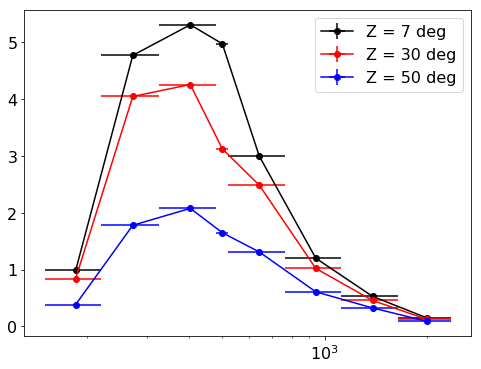

In [724]:
plt.errorbar(analysis1.dataset.energies.energy_bin_cen,
             result1.diff_flux_map,#/7.744676455292198,
             xerr=analysis1.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,len(analysis1.dataset.energies.energy_bin_cen)),fmt='o-',label='Z = 7 deg')

plt.errorbar(analysis2.dataset.energies.energy_bin_cen,
             result2.diff_flux_map,#/1.7104258061250863,
             xerr=analysis2.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,len(analysis2.dataset.energies.energy_bin_cen)),fmt='o-',label='Z = 30 deg')

plt.errorbar(analysis3.dataset.energies.energy_bin_cen,
             result3.diff_flux_map,#/,0.8345885657790918,
             xerr=analysis3.dataset.energies.energy_bin_wid,
             yerr=np.repeat(0,len(analysis3.dataset.energies.energy_bin_cen)),fmt='o-',label='Z = 50 deg')


plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,3500)

"""x = np.logspace(np.log10(150),np.log10(3450),100)
plt.plot(x,9.1e-4*(x/100)**(-2.17))"""

plt.legend()

In [ ]:
import

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################

Start fitting energy bin 1/8...

Energy range: 150-220 keV ...
Summary for energy bin 1/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 4900.2   33.11 689.15 3474.0 4446.6 4906.5 5336.5 6446.3    433    1.0
Abg[1]  2.7e-4  3.2e-6 7.1e-5 1.4e-4 2.2e-4 2.6e-4 3.1e-4 4.2e-4    505    1.0

Samples were drawn using NUTS at Mon Nov 30 22:59:27 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/8...

Energy range: 220-325 k

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 3/8...

Energy range: 325-480 keV ...
Summary for energy bin 3/8:



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  3.6e4  109.06 1938.9  3.3e4  3.5e4  3.7e4  3.8e4  4.0e4    316    1.0
Abg[1]  6.3e-4  3.3e-6 6.8e-5 5.0e-4 5.8e-4 6.3e-4 6.8e-4 7.7e-4    419    1.0

Samples were drawn using NUTS at Mon Nov 30 23:00:00 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 4/8...

Energy range: 480-520 keV ...
Summary for energy bin 4/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
po

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 5/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  3.1e4   88.02 1863.9  2.8e4  3.0e4  3.1e4  3.2e4  3.5e4    448    1.0
Abg[1]  7.6e-4  3.4e-6 7.1e-5 6.1e-4 7.1e-4 7.5e-4 8.0e-4 8.9e-4    428    1.0

Samples were drawn using NUTS at Mon Nov 30 23:00:34 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 6/8...

Energy range: 765-1120 keV ...
Summary for energy bin 6/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  1.8e4   62.55 1357.7  1.5e4  1.7e4  1.8e4  1.8e4  2.1e4    471    1.0
Abg[1]  7.1e-4  2.9e-6 6.5e-5 5.8e-4 6.7e-4 7.1e-4 7.5e-4 8.4e-4    515    1.0

Samples were drawn using NUTS at Mon Nov 30 23:00:52 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 7/8...

Energy range: 1120-1650 keV ...
Summary for energy bin 7/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  1.2e4   62.92 1125.3  1.0e4  1.2e4  1.2e4  1.3e4  1.5e4    320    1.0
Abg[1]  5.8e-4  4.6e-6 7.5e-5 4.4e-4 5.3e-4 5.9e-4 6.3e-4 7.3e-4    267    1.0

Samples were drawn using NUTS at Mon Nov 30 23:01:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


###################################################################
###################################################################

Start fitting energy bin 8/8...

Energy range: 1650-2350 keV ...
Summary for energy bin 8/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 5393.8   32.73 719.03 4154.7 4868.4 5335.5 5890.1 6914.9    483    1.0
Abg[1]  3.3e-4  3.1e-6 6.7e-5 2.1e-4 2.8e-4 3.2e-4 3.7e-4 4.7e-4    461    1.0

Samples were drawn using NUTS at Mon Nov 30 23:01:34 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################


Gradient evaluation took 0.000891 seconds
1000 transi

In [704]:
result2.fit(iters=1000,pars=['Abg','flux','model_values','model_sky','model_bg','model_tot'])

###################################################################

Start fitting energy bin 1/8...

Energy range: 150-220 keV ...
Summary for energy bin 1/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  60.06    0.46   8.25  44.77  54.32  59.46  65.08  77.29    319    1.0
Abg[1]  2.5e-4  3.4e-6 6.7e-5 1.4e-4 2.0e-4 2.5e-4 3.0e-4 3.9e-4    382    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:21 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/8...

Energy range: 220-325 k

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 2/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 426.18    1.32   20.1 386.29 412.39 425.45 439.75 464.78    233    1.0
Abg[1]  1.9e-4  3.3e-6 6.6e-5 7.9e-5 1.5e-4 1.9e-4 2.4e-4 3.3e-4    404    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 3/8...

Energy range: 325-480 keV ...
Summary for energy bin 3/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)



###################################################################
###################################################################

Start fitting energy bin 4/8...

Energy range: 480-520 keV ...
Summary for energy bin 4/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 125.95     0.5  10.96 104.88 118.18 125.81 133.19  147.3    483    1.0
Abg[1]  3.1e-4  3.4e-6 7.5e-5 1.7e-4 2.6e-4 3.1e-4 3.6e-4 4.7e-4    474    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
########################################################

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 608.36    1.54  25.93 560.05 588.79 606.99 625.41 665.37    282    1.0
Abg[1]  2.0e-4  3.5e-6 7.0e-5 7.5e-5 1.4e-4 1.9e-4 2.4e-4 3.5e-4    386    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:28 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 6/8...

Energy range: 765-1120 keV ...
Summary for energy bin 6/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
p

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)



###################################################################
###################################################################

Start fitting energy bin 7/8...

Energy range: 1120-1650 keV ...
Summary for energy bin 7/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 242.46    0.93  15.49 214.08 230.67 243.61 252.55 272.78    276    1.0
Abg[1]  1.3e-4  3.3e-6 6.2e-5 3.3e-5 8.2e-5 1.2e-4 1.7e-4 2.6e-4    354    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
######################################################

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected b

In [705]:
result3.fit(iters=1000,pars=['Abg','flux','model_values','model_sky','model_bg','model_tot'])

###################################################################

Start fitting energy bin 1/8...

Energy range: 150-220 keV ...
Summary for energy bin 1/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  23.24     0.2   4.77  14.77  19.86  23.05  26.38  33.32    582    1.0
Abg[1]  3.1e-4  3.7e-6 7.2e-5 1.8e-4 2.6e-4 3.1e-4 3.5e-4 4.5e-4    379    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 2/8...

Energy range: 220-325 k

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 2/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  185.7    0.77  13.68 160.27 175.48 185.25 194.68 215.18    319   1.02
Abg[1]  3.8e-4  2.9e-6 6.9e-5 2.6e-4 3.4e-4 3.8e-4 4.3e-4 5.3e-4    565    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 3/8...

Energy range: 325-480 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 3/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 320.68    0.93  17.06 289.93 307.97 320.57 331.52 355.44    336    1.0
Abg[1]  1.7e-4  4.5e-6 7.2e-5 4.5e-5 1.1e-4 1.6e-4 2.1e-4 3.1e-4    254    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:39 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 4/8...

Energy range: 480-520 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 4/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  64.94    0.42   7.81  50.85  59.27   64.9  69.83  81.68    350    1.0
Abg[1]  3.1e-4  3.1e-6 6.4e-5 1.9e-4 2.7e-4 3.1e-4 3.5e-4 4.5e-4    430    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 5/8...

Energy range: 520-765 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 5/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 319.57    1.51  19.47 284.84 305.56 319.09 331.69 356.51    166    1.0
Abg[1]  1.9e-4  4.1e-6 6.4e-5 7.0e-5 1.5e-4 1.8e-4 2.3e-4 3.2e-4    246    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 6/8...

Energy range: 765-1120 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 6/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]  215.8    0.75  13.86 191.23 205.84 214.77 223.97 248.24    343   1.01
Abg[1]  1.9e-4  5.3e-6 7.2e-5 5.8e-5 1.4e-4 1.8e-4 2.4e-4 3.5e-4    188    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 7/8...

Energy range: 1120-1650 keV ...


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Summary for energy bin 7/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 172.39    0.89  13.44 147.87 162.37  171.8 181.31 198.62    227   1.01
Abg[1]  1.3e-4  3.8e-6 7.2e-5 2.4e-5 7.1e-5 1.1e-4 1.7e-4 2.9e-4    353    1.0

Samples were drawn using NUTS at Mon Nov 30 19:38:49 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
###################################################################
###################################################################

Start fitting energy bin 8/8...

Energy range: 1650-2350 keV ...
Summary for energy bin 8/8:

Inference for Stan model: anon_model_666f42d8e949bfaf2d5a9470c57200bd.
1 chains, each with ite

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[1] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: poisson_lpmf: Rate parameter[544] is nan, but must not be nan!  (in 'COSImodfit.stan' at line 80)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



In [635]:
sky_data1.dataset.binned_data.shape

(1, 8, 30, 1145)

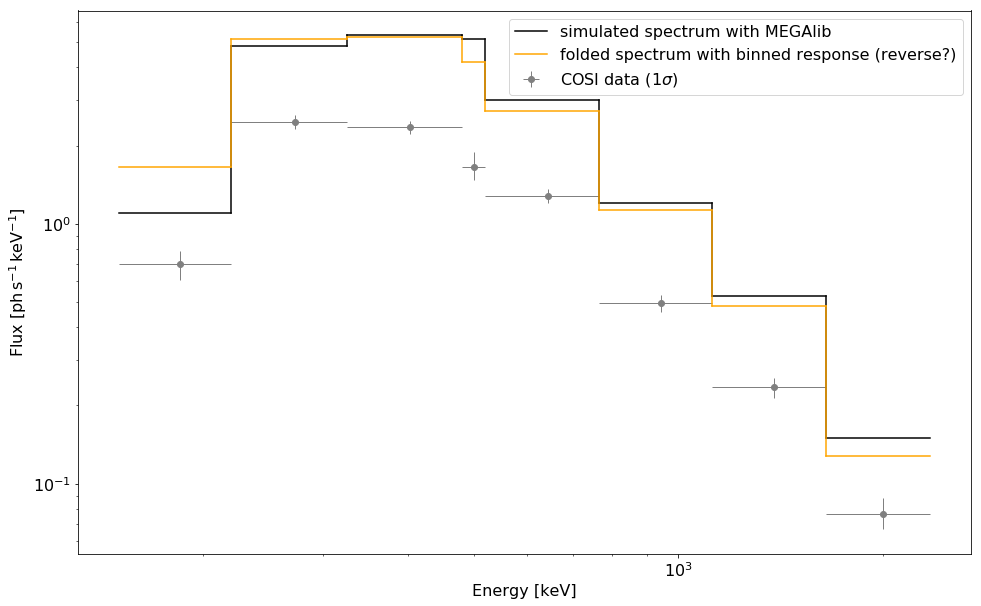

In [985]:
fig, ax = plt.subplots(figsize=(16,10))

ax.errorbar(analysis1.dataset.energies.energy_bin_cen[0:9],
             result1.diff_flux[0:9],
             xerr=analysis1.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result1.diff_flux_err[0:9,:].T),#*domega1,#/analysis.dataset.energies.energy_bin_wid[0:9]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')


ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,s^{-1}\,keV^{-1}}$]')

#ax.axhline(0,linestyle=':')

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(0,2200)


for i in range(analysis1.dataset.energies.n_energy_bins-1):
    ax.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_crab_rate1[i],2),'k-')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        ax.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_crab_rate1[i],
                  sim_crab_rate1[i+1]],'k-')
ax.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_crab_rate1[-1],2),'k-',label='simulated spectrum with MEGAlib')   

fac = 8500#11309.7
for i in range(rsp.n_e-1+off):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(crab_folded_counts1[i]/rsp.e_wid[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1+off)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [crab_folded_counts1[i]/rsp.e_wid[i]*fac,
                  crab_folded_counts1[i+1]/rsp.e_wid[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2+off],
              rsp.e_max[-1+off]],
             np.repeat(crab_folded_counts1[-1]/rsp.e_wid[-1+off]*fac,2),'-',color='orange',label='folded spectrum with binned response (reverse?)')




ax.legend()

AttributeError: 'fit' object has no attribute 'diff_flux'

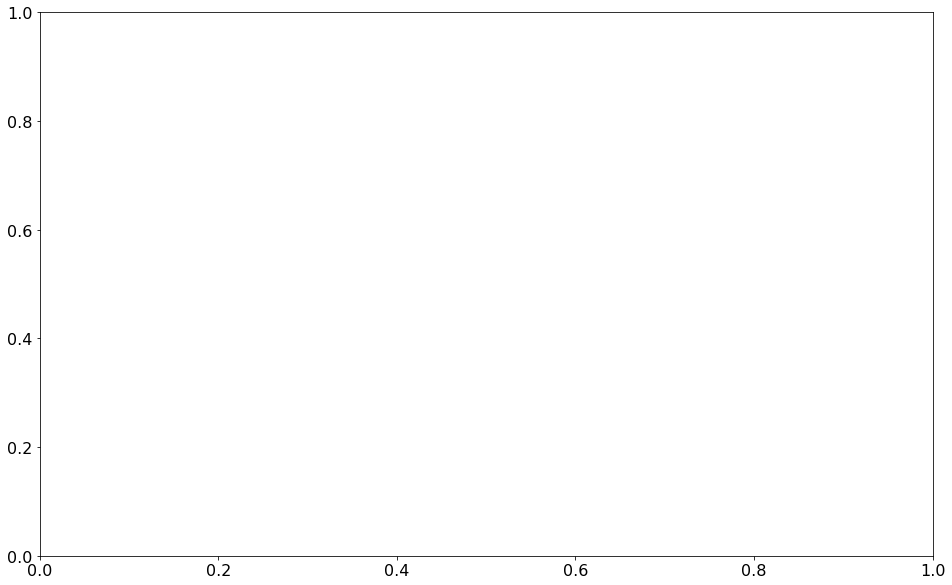

In [980]:
fig, ax = plt.subplots(figsize=(16,10))

ax.errorbar(analysis2.dataset.energies.energy_bin_cen[0:9],
             result2.diff_flux[0:9]*1.,
             xerr=analysis2.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result2.diff_flux_err[0:9,:].T)*1.,#*domega1,#/analysis.dataset.energies.energy_bin_wid[0:9]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')


ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,s^{-1}\,keV^{-1}}$]')

#ax.axhline(0,linestyle=':')

#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(0,2200)


for i in range(analysis2.dataset.energies.n_energy_bins-1):
    ax.plot([analysis2.dataset.energies.energy_bin_min[i],analysis2.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate2[i],2),'k-')
    if ((i >= 0) & (i<analysis2.dataset.energies.n_energy_bins-1)):
        ax.plot(np.repeat(analysis2.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate2[i],
                  sim_sky_rate2[i+1]],'k-')
ax.plot([analysis2.dataset.energies.energy_bin_max[-2],
              analysis2.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate2[-1],2),'k-',label='simulated spectrum with MEGAlib')   

fac = 11309.7
for i in range(rsp.n_e-1+off):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_folded_counts2[i]/rsp.e_wid[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1+off)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts2[i]/rsp.e_wid[i]*fac,
                  plaw_folded_counts2[i+1]/rsp.e_wid[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2+off],
              rsp.e_max[-1+off]],
             np.repeat(plaw_folded_counts2[-1]/rsp.e_wid[-1+off]*fac,2),'-',color='orange',label='folded spectrum with binned response')




ax.legend()

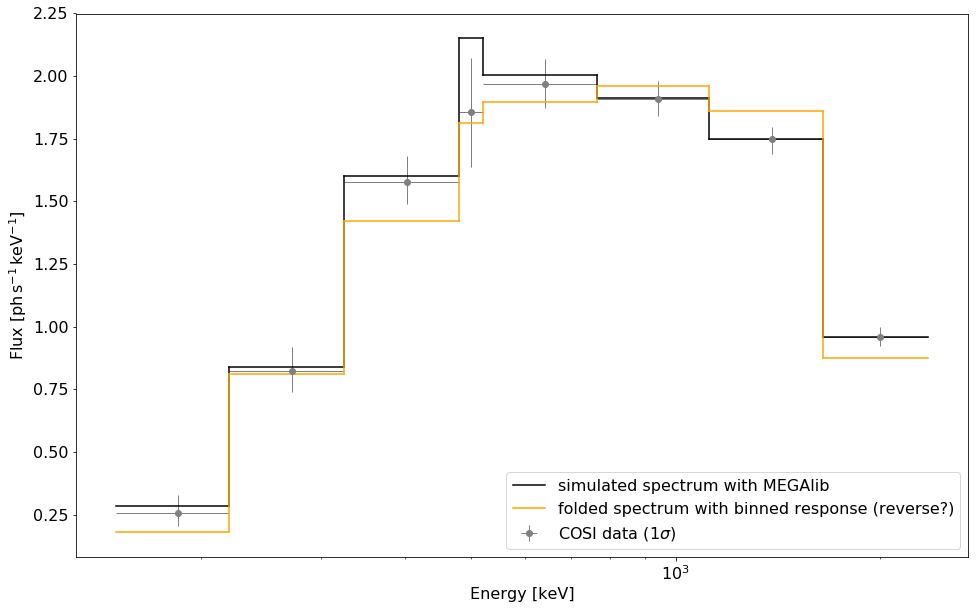

In [639]:
fig, ax = plt.subplots(figsize=(16,10))

ax.errorbar(analysis3.dataset.energies.energy_bin_cen[0:9],
             result3.diff_flux[0:9]*1,
             xerr=analysis3.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result3.diff_flux_err[0:9,:].T)*1,#*domega1,#/analysis.dataset.energies.energy_bin_wid[0:9]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')


ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,s^{-1}\,keV^{-1}}$]')

#ax.axhline(0,linestyle=':')

#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(0,2200)


for i in range(analysis3.dataset.energies.n_energy_bins-1):
    ax.plot([analysis3.dataset.energies.energy_bin_min[i],analysis3.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate3[i],2),'k-')
    if ((i >= 0) & (i<analysis3.dataset.energies.n_energy_bins-1)):
        ax.plot(np.repeat(analysis3.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate3[i],
                  sim_sky_rate3[i+1]],'k-')
ax.plot([analysis3.dataset.energies.energy_bin_max[-2],
              analysis3.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate3[-1],2),'k-',label='simulated spectrum with MEGAlib')   

fac = 11309.7
for i in range(rsp.n_e-1+off):
    plt.plot([rsp.e_min[i],rsp.e_min[i+1]],
             np.repeat(plaw_folded_counts3[i]/rsp.e_wid[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1+off)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts3[i]/rsp.e_wid[i]*fac,
                  plaw_folded_counts3[i+1]/rsp.e_wid[i+1]*fac],'-',color='orange')
plt.plot([rsp.e_max[-2+off],
              rsp.e_max[-1+off]],
             np.repeat(plaw_folded_counts3[-1]/rsp.e_wid[-1+off]*fac,2),'-',color='orange',label='folded spectrum with binned response (reverse?)')




ax.legend()

"\nfor i in range(analysis.dataset.energies.n_energy_bins-1):\n    plt.plot([analysis.dataset.energies.energy_bin_min[i],\n              analysis.dataset.energies.energy_bin_min[i+1]],\n             np.repeat(plaw_folded_counts[i],2),'r-')\n    if ((i >= 0) & (i<rsp.n_e-1)):\n        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),\n                 [plaw_folded_counts[i],\n                  plaw_folded_counts[i+1]],'r-')"

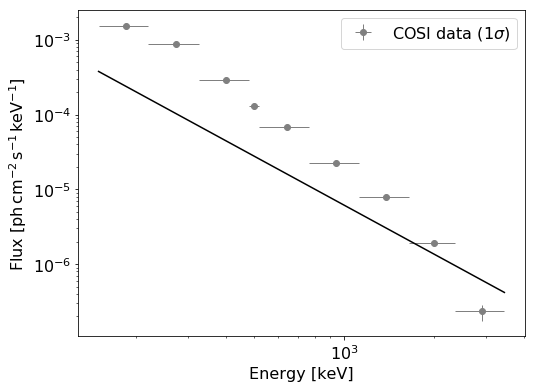

In [811]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:9],
             result.diff_flux[0:9]*domega,#/analysis.dataset.energies.energy_bin_wid[0:9]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:9],
             yerr=np.abs(result.diff_flux_err[0:9,:].T)*domega,#/analysis.dataset.energies.energy_bin_wid[0:9]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($1\sigma$)')


ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

#ax.axhline(0,linestyle=':')

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim(0,1e-1)
ax.legend()

x = np.logspace(np.log10(150),np.log10(3450),100)
plt.plot(x,9.1e-4*(x/100)**(-2.17))

"""
for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],
              analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(plaw_folded_counts[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [plaw_folded_counts[i],
                  plaw_folded_counts[i+1]],'r-')"""
        

In [264]:
analysis.dataset.energies.energy_bin_wid[0:]*2

array([  70.,  105.,  155.,   40.,  245.,  355.,  530.,  700., 1100.])

In [88]:
result.diff_flux[0:]*analysis.dataset.energies.energy_bin_wid[0:]*2

array([0.03570014, 0.02470134, 0.01123902, 0.00770062, 0.00383759,
       0.00151608, 0.00054799, 0.00019681])

In [89]:
plaw_true_fluxes

NameError: name 'plaw_true_fluxes' is not defined

In [ ]:
break

In [194]:
result.diff_flux[0:]*analysis.dataset.energies.energy_bin_wid[0:]*2/plaw_true_fluxes[0:-2]

array([2.05720505, 2.16444916, 1.55957286, 7.02162191, 0.93434126,
       0.58454296, 0.32569882, 0.20330551])

In [ ]:
blub = np.array([rsp.sky_response[i].shape[1] for i in range(8)])

In [ ]:
blub

In [ ]:
plt.pcolormesh(rsp.dOmega)

In [ ]:
plaw

In [ ]:
%aimport COSIpy_tools

In [ ]:
from COSIpy_tools import get_image_response_from_pixelhit_hourly, zenaziGrid, one_func

In [429]:
# we define our sky-grid on a regular 5x5 pixel grid for testing (later finer grid)
binsize = 6.

deg2rad = np.pi/180.

# l and b pixel edges
l_arrg = np.linspace(-180,180,int(360/binsize)+1)
b_arrg = np.linspace(-90,90,int(180/binsize)+1)
# number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)
# making a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
# choosing the centre points as representative
l_arr = l_arrg[0:-1]+binsize/2
b_arr = b_arrg[0:-1]+binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

In [430]:
np.sum(domega),4*np.pi

(12.566370614359174, 12.566370614359172)

In [431]:
# calculate the zeniths and azimuths on that grid for all times
zensgrid,azisgrid = zenaziGrid(pointing.xpoins[:,0],pointing.xpoins[:,1],
                               pointing.ypoins[:,0],pointing.ypoins[:,1],
                               pointing.zpoins[:,0],pointing.zpoins[:,1],
                               L_ARR.ravel(),B_ARR.ravel())
# reshape for next routines ... 
zensgrid = zensgrid.reshape(n_b,n_l,len(pointing.xpoins))
azisgrid = azisgrid.reshape(n_b,n_l,len(pointing.xpoins))

In [432]:
zensgrid.shape

(30, 60, 48)

In [515]:
ec = 4

In [516]:
nonzero_idx = background.calc_this[ec]
nonzero_idx.shape

(3037,)

In [517]:
sky_response_CDS = rsp.rsp.response_grid_normed.reshape(n_b,
                                                        n_l,
                                                        analysis.dataset.phis.n_phi_bins*\
                                                        analysis.dataset.fisbels.n_fisbel_bins,10,10)[:,:,nonzero_idx,ec,ec]

In [518]:
sky_response_CDS.shape

(30, 60, 3037)

In [519]:
tmp = get_image_response_from_pixelhit_hourly(Response=sky_response_CDS,
                                              zenith=zensgrid,
                                              azimuth=azisgrid,
                                              dt=pointing.dtpoins,
                                              n_hours=analysis.dataset.times.n_time_bins,
                                              binsize=6,
                                              cut=60.,
                                              altitude_correction=False,
                                              al=np.ones(len(pointing.dtpoins)))

48


In [520]:
analysis.dataset.times.n_time_bins

24

In [521]:
len(pointing.dtpoins)

48

In [522]:
tmp.shape

(24, 30, 60, 3037)

In [523]:
def Gaussian2D(ll,bb,A0,l0,b0,sl,sb,binsize=5):
    #return A0/(2*np.pi*sl*sb*(np.pi/180)**2)*np.exp(-(ll-l0)**2/(2*sl**2)-(bb-b0)**2/(2*sb**2))
    shape = np.exp(-(ll-l0)**2/(2*sl**2)-(bb-b0)**2/(2*sb**2))
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

In [524]:
Crab_Gaussian = Gaussian2D(L_ARR,B_ARR,1e-2,184-360,-5.5,1,1,binsize=6)

In [525]:
conv_sky_Crab = 0

for i in tqdm(range(n_b),'loop over latitudes:'):
    for j in range(n_l):
        conv_sky_Crab += tmp[:,i,j,:]*Crab_Gaussian[i,j]

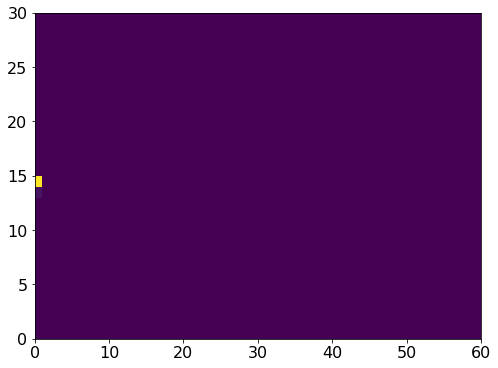

In [526]:
plt.pcolormesh(Crab_Gaussian)

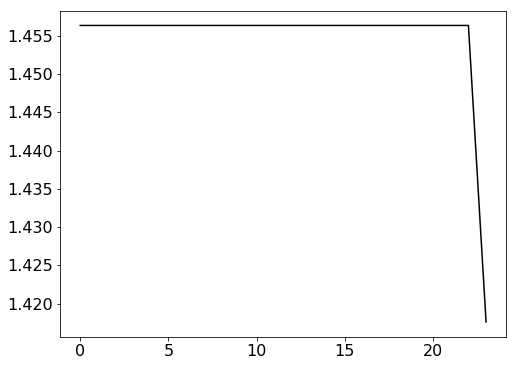

In [527]:
plt.plot(np.sum(conv_sky_Crab,axis=1))

In [528]:
np.sum(conv_sky_Crab)*3600/analysis.dataset.energies.energy_bin_wid[ec]/2

513.0157197873322

In [529]:
sim_sky_rate

array([ 50., 406., 735., 158., 680., 411., 283., 100.,  14.])

In [530]:
sim_sky_rate[ec]/(np.sum(conv_sky_Crab)*3600/analysis.dataset.energies.energy_bin_wid[ec]/2)

1.3254954454064103

In [304]:
plaw_true_fluxes

array([0.01750875, 0.01135672, 0.00719357, 0.0011113 , 0.00411951,
       0.0025971 , 0.00168488, 0.00099547, 0.0007034 , 0.00043692])

In [ ]:
for i in range(rsp.n_e-1):
    plt.plot([rsp.e_min[i],
              rsp.e_min[i+1]],|
             np.repeat(plaw_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_true_fluxes[i],
                  plaw_true_fluxes[i+1]],'r-')
plt.plot([rsp.e_max[-2],
              rsp.e_max[-1]],
             np.repeat(plaw_true_fluxes[-1],2),'r-')
        
plt.xscale('log')
plt.yscale('log')

In [70]:
rsp.rsp.response_grid_normed.shape

(30, 60, 30, 1145, 10, 10)

In [71]:
0.01087097/3.08e-4

35.29535714285714

In [72]:
0.00851473/3.08e-4

27.645227272727272

In [73]:
0.00702343/3.08e-4

22.803344155844155

In [ ]:
plaw_folded_counts = np.dot(plaw_true_fluxes, tmp/np.mean(np.diag(tmp)))/ rsp.e_wid

In [ ]:
plaw_folded_counts = bla*plaw_true_fluxes[0:-2]/rsp.e_wid[0:-2]**2#bla/rsp.e_wid[0:-2]*rsp.e_cen[0:-2]**(-2.17)/np.mean(rsp.e_cen[0:-2]**(-2.17)*0.011)

In [115]:
plaw_folded_counts1/sim_sky_rate1

array([1.96325859e-05, 2.80048167e-05, 3.64021316e-05, 8.79476490e-05,
       5.01640802e-05, 7.13406022e-05, 8.19828641e-05, 1.21734192e-04,
       3.78028754e-04])

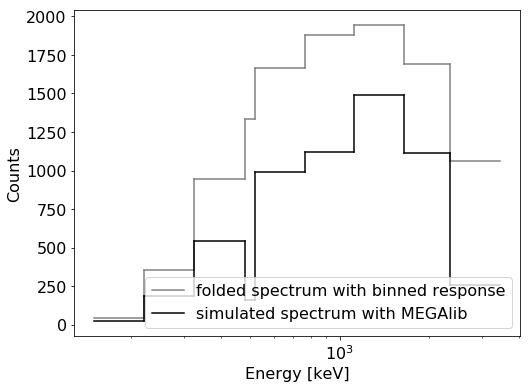

In [127]:
fac = 7e6#/2.2#6**2#86400/0.01087097#10000000#sky_data1.dataset.times.times_wid

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(plaw_folded_counts1[i],2)*fac,'-',color='gray')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [plaw_folded_counts1[i]*fac,
                  plaw_folded_counts1[i+1]*fac],'-',color='gray')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(plaw_folded_counts1[-1]*fac,2),'-',color='gray',label='folded spectrum with binned response')
        
    
sim_sky_rate1 = np.sum(sky_data1.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate1[i],2),'k-')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate1[i],
                  sim_sky_rate1[i+1]],'k-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate1[-1],2),'k-',label='simulated spectrum with MEGAlib')   

"""
sim_sky_rate4 = np.sum(sky_data4.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate4[i],2),'k--')
    if ((i >= 0) & (i<analysis1.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis1.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate4[i],
                  sim_sky_rate4[i+1]],'k--')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate4[-1],2),'k--')  """
    
    
        
"""for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(plaw_folded_counts2[i],2)*fac,'-',color='orange')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts2[i]*fac,
                  plaw_folded_counts2[i+1]*fac],'-',color='orange')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(plaw_folded_counts2[-1],2),'-',color='orange')
        
    
for i in range(analysis1.dataset.energies.n_energy_bins-1):
    plt.plot([analysis1.dataset.energies.energy_bin_min[i],analysis1.dataset.energies.energy_bin_min[i+1]],
             np.repeat(plaw_folded_counts3[i],2)*fac,'-',color='cyan')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts3[i]*fac,
                  plaw_folded_counts3[i+1]*fac],'-',color='cyan')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(plaw_folded_counts3[-1],2),'-',color='cyan')        

        


        
sim_sky_rate2 = np.sum(sky_data2.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis2.dataset.energies.n_energy_bins-1):
    plt.plot([analysis2.dataset.energies.energy_bin_min[i],analysis2.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate2[i],2),'r-')
    if ((i >= 0) & (i<analysis2.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis2.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate2[i],
                  sim_sky_rate2[i+1]],'r-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate2[-1],2),'r-')

sim_sky_rate13 = np.sum(sky_data3.dataset.binned_data,axis=(0,2,3))#/analysis1.dataset.energies.energy_bin_wid/2

for i in range(analysis3.dataset.energies.n_energy_bins-1):
    plt.plot([analysis3.dataset.energies.energy_bin_min[i],analysis3.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate13[i],2),'b-')
    if ((i >= 0) & (i<analysis3.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis3.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate13[i],
                  sim_sky_rate13[i+1]],'b-')
plt.plot([analysis1.dataset.energies.energy_bin_max[-2],
              analysis1.dataset.energies.energy_bin_max[-1]],
             np.repeat(sim_sky_rate13[-1],2),'b-')"""
        
        
plt.xscale('log')

plt.xlabel('Energy [keV]')
plt.ylabel('Counts')

#plt.ylim(0,2100)

plt.legend()

#plt.yscale('log')

In [630]:
rsp.rsp.response_grid_normed.shape

(30, 60, 30, 1145, 10, 10)

In [633]:
tmp = np.sum(rsp.rsp.response_grid_normed[1,8,:,:,0:,0:],axis=(0,1))

In [937]:
tmp2 = (tmp[0:-1,0:-1].T)/erg_mat[1]**0/(np.sum((tmp[0:-1,0:-1].T)/erg_mat[1]**0,axis=0))

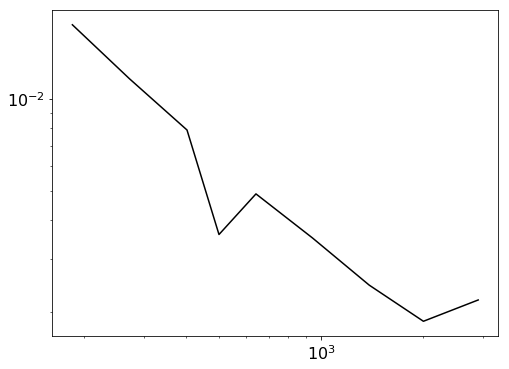

In [942]:
plt.loglog(rsp.e_cen[0:9],np.dot(tmp2.T,plaw_true_fluxes[0:9]))

In [968]:
rsp.rsp.response_grid_normed.shape

(30, 60, 30, 1145, 10, 10)

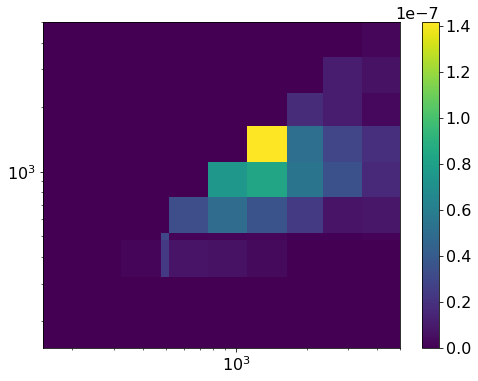

In [971]:
plt.pcolormesh(rsp.e_edges,rsp.e_edges,rsp.rsp.response_grid_normed[0,30,3,14,:,:].T/erg_mat2[0])
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

In [960]:
response.find_CDS_indices(20*deg2rad,10*deg2rad,180*deg2rad,rsp.rsp.phis.phi_cen,rsp.rsp.fisbels.lat_cen,rsp.rsp.fisbels.lon_cen)

(3, 14)

In [959]:
rsp.rsp.phis.phi_cen

array([0.05235988, 0.15707963, 0.26179939, 0.36651914, 0.4712389 ,
       0.57595865, 0.68067841, 0.78539816, 0.89011792, 0.99483767,
       1.09955743, 1.20427718, 1.30899694, 1.41371669, 1.51843645,
       1.6231562 , 1.72787596, 1.83259571, 1.93731547, 2.04203522,
       2.14675498, 2.25147474, 2.35619449, 2.46091425, 2.565634  ,
       2.67035376, 2.77507351, 2.87979327, 2.98451302, 3.08923278])

In [958]:
np.argmin(np.abs(20-rsp.rsp.phis.phi_cen))

29

In [956]:
rsp.rsp.fisbels.lat_cen

array([0.05235988, 0.15707963, 0.26179939, 0.36651914, 0.4712389 ,
       0.57595865, 0.68067841, 0.78539816, 0.89011792, 0.99483767,
       1.09955743, 1.20427718, 1.30899694, 1.41371669, 1.51843645,
       1.6231562 , 1.72787596, 1.83259571, 1.93731547, 2.04203522,
       2.14675498, 2.25147474, 2.35619449, 2.46091425, 2.565634  ,
       2.67035376, 2.77507351, 2.87979327, 2.98451302, 3.08923278])

In [657]:
aa = np.array([[1,2,],[3,0]])

In [661]:
aa/np.array([2,3])

array([[0.5       , 0.66666667],
       [1.5       , 0.        ]])

Text(0, 0.5, '$E_{measured}$ [keV]')

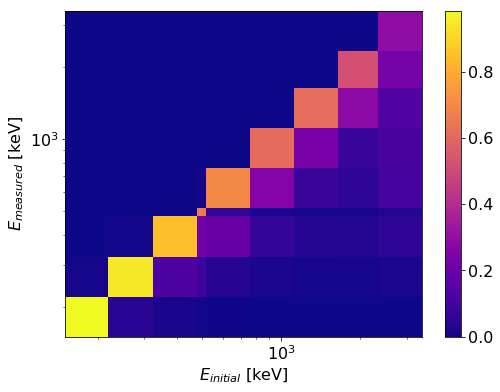

In [936]:
plt.pcolormesh(rsp.e_edges[0:-1],rsp.e_edges[0:-1],(tmp[0:-1,0:-1].T)/erg_mat[1]**0/(np.sum((tmp[0:-1,0:-1].T)/erg_mat[1]**0,axis=0)),
              cmap=plt.cm.plasma)#,vmin=0.9,vmax=1.1)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel(r'$E_{initial}$ [keV]')
plt.ylabel(r'$E_{measured}$ [keV]')
#plt.xlim(100,5000)
#plt.ylim(100,5000)

In [702]:
tmp[0:9,0:9].shape

(9, 9)

In [726]:
erg_mat2 = np.meshgrid(rsp.e_wid,rsp.e_wid)

In [727]:
erg_mat2

[array([[  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550]]),
 array([[  70,   70,   70,   70,   70,   70,   70,   70,   70,   70],
        [ 105,  105,  105,  105,  105,  105,  105,  105,  105,  105],
        [ 155,  155,  155,  155,  155,  155,  155,  155,  155,  155],
        [  40,   40,   40,   40,   40,   40,   40,   40,   40,   40],
        [ 245,  24

In [728]:
erg_mat

[array([[  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100]]),
 array([[  70,   70,   70,   70,   70,   70,   70,   70,   70],
        [ 105,  105,  105,  105,  105,  105,  105,  105,  105],
        [ 155,  155,  155,  155,  155,  155,  155,  155,  155],
        [  40,   40,   40,   40,   40,   40,   40,   40,   40],
        [ 245,  245,  245,  245,  245,  245,  245,  245,  245],
        [ 355,  355,  355,  355,  355,  355,  355,  355,  355],
        [ 530,  530,  530,  530,  530,

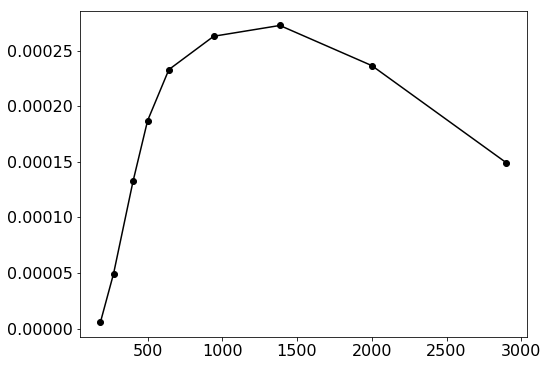

In [781]:
plt.plot(rsp.e_cen[0:9],np.sum(tmp[0:9,0:9]/(erg_mat2[1][0:9,0:9]),axis=1),'o-')

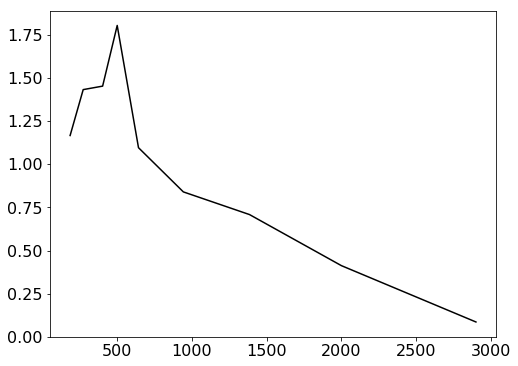

In [934]:
plt.plot(rsp.e_cen[0:9],np.sum((tmp[0:-1,0:-1].T)/erg_mat[1]/(np.sum((tmp[0:-1,0:-1].T)/erg_mat[1],axis=0)),axis=1))

In [223]:
zens3

array([50.15201229, 50.15201229, 50.15201229, 50.15201229, 50.15201229,
       50.15201229, 50.15201229, 50.15201229, 50.15201229, 50.15201229,
       50.15201229, 50.15201229, 50.15201229, 50.15201229, 50.15201229,
       50.15201229, 50.15201229, 50.15201229, 50.15201229, 50.15201229,
       50.15201229, 50.15201229, 50.15201229, 50.15201229])

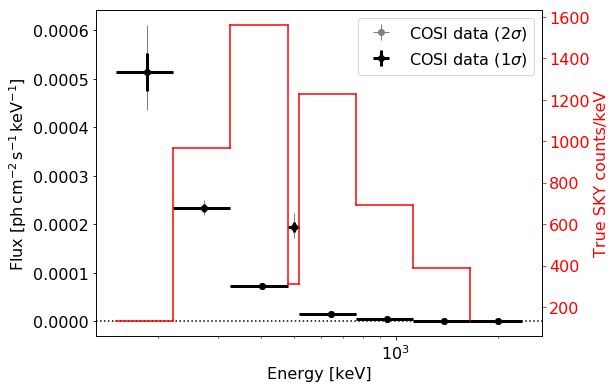

In [210]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err2[0:,:].T),#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($2\sigma$)')

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err[0:,:].T),#/(180/np.pi),#analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=3,color='black',
             label=r'COSI data ($1\sigma$)')

ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax.axhline(0,linestyle=':')

#ax.set_yscale('log')
#ax.set_ylim(0,1e-1)
ax.legend()

#ax.set_ylim(-0.005,0.05)
lax_ylim = ax.get_ylim()

ax2 = plt.twinx()
"""
plt.step(analysis.dataset.energies.energy_bin_cen+2.5,
         np.sum(sky_data.dataset.binned_data,axis=(0,2,3))/analysis.dataset.energies.energy_bin_wid/2,
         where='mid',color='red')"""

sim_sky_rate = np.sum(sky_data.dataset.binned_data,axis=(0,2,3))#/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    ax2.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate[i],2),'r-')
    if ((i >= 0) & (i<analysis.dataset.energies.n_energy_bins-1)):
        ax2.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate[i],
                  sim_sky_rate[i+1]],'r-')

ax2.set_ylabel('True SKY counts/keV',color='red')

ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')

rax_ylim = ax2.get_ylim()

#ax2.set_ylim(rax_ylim[0]*np.diff(lax_ylim)/(result.diff_flux[0:]/analysis.dataset.energies.energy_bin_wid[0:]/2).max(),
#             rax_ylim[0]+rax_ylim[1]*lax_ylim[1]/(result.diff_flux[0:]/analysis.dataset.energies.energy_bin_wid[0:]/2).max())

ax2.set_xscale('log')
#ax2.set_yscale('log')
#plt.ylim()

In [ ]:
sky_data.dataset.times.times_wid

In [ ]:
fac = 100**3.5#000*sky_data.dataset.times.times_wid

for i in range(rsp.n_e-3):
    plt.plot([rsp.e_min[i],
              rsp.e_min[i+1]],
             np.repeat(plaw_folded_counts[i],2)*fac,'r-')
    if ((i >= 0) & (i<rsp.n_e-3)):
        plt.plot(np.repeat(rsp.e_min[i+1],2),
                 [plaw_folded_counts[i]*fac,
                  plaw_folded_counts[i+1]*fac],'r-')
        

plt.xscale('log')
#plt.yscale('log')

sim_sky_rate = np.sum(sky_data.dataset.binned_data,axis=(0,2,3))/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(sim_sky_rate[i],2),'b-')
    if ((i >= 0) & (i<analysis.dataset.energies.n_energy_bins-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [sim_sky_rate[i],
                  sim_sky_rate[i+1]],'b-')

ax2.set_ylabel('True SKY counts/keV',color='red')

plt.ylim(0,)

In [ ]:
use_rsp = [find_nearest(rsp.e_cen,erg) for erg in analysis.dataset.energies.energy_bin_cen]

In [ ]:
use_rsp

In [ ]:
result.diff_flux# * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
rsp.e_edges[use_rsp]

In [ ]:
analysis.dataset.energies.energy_bin_wid*2

In [ ]:
analysis.dataset.energies.energy_bin_wid*2 / rsp.e_wid[use_rsp]

In [ ]:
rsp.e_wid

In [ ]:
analysis.dataset.energies.energy_bin_cen

In [ ]:
result.diff_flux * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
result.diff_flux[3]/1e-3#/(analysis.dataset.energies.energy_bin_wid*2)

In [ ]:
np.max(np.abs(result.diff_flux_err),axis=1) * (analysis.dataset.energies.energy_bin_wid*2) / rsp.e_wid[use_rsp]

In [ ]:
2*np.pi

In [ ]:
result.diff_flux * rsp.e_wid[use_rsp] / (analysis.dataset.energies.energy_bin_wid*2)**3

In [ ]:
result.diff_flux * (analysis.dataset.energies.energy_bin_wid*2)**2 / rsp.e_wid[use_rsp]

In [ ]:
180/np.pi

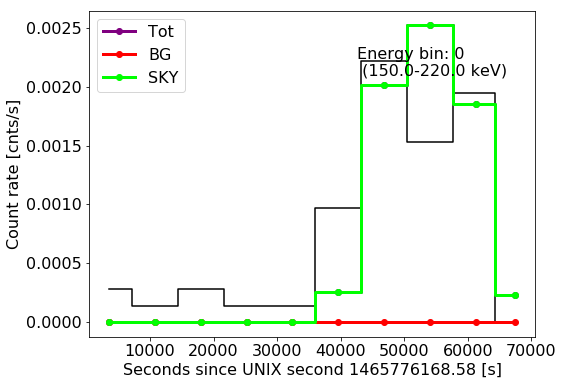

In [1030]:
b = 0

analysis1.dataset.plot_lightcurve(b)

#plt.twinx()

plt.step(analysis1.dataset.times.times_cen,
         np.median(result1.fit_pars[b]['model_tot'],axis=0)/(analysis1.dataset.times.times_wid*2),
         color='purple',where='mid',marker='o',linewidth=3,label='Tot')

plt.step(analysis1.dataset.times.times_cen,
         np.median(result1.fit_pars[b]['model_bg'],axis=0)/(analysis1.dataset.times.times_wid*2),
         color='red',where='mid',marker='o',linewidth=3,label='BG')

plt.step(analysis1.dataset.times.times_cen,
         np.median(result1.fit_pars[b]['model_sky'],axis=(0,1))/(analysis1.dataset.times.times_wid*2),
         color='lime',where='mid',marker='o',linewidth=3,label='SKY')

plt.legend(loc=2)

#plt.plot(analysis.dataset.times.times_max[0::2],
#         np.median(result.fit_pars[b]['Abg'],axis=0),color='red')
#plt.plot(analysis.dataset.times.times_cen,
#         np.sum(rsp.sky_response[b],axis=1),color='lime')

In [ ]:
break

In [982]:
np.logspace(np.log10(150),np.log10(480),3)

array([150.       , 268.3281573, 480.       ])

In [985]:
np.logspace(np.log10(520),np.log10(1780),3)

array([ 520.        ,  962.08107766, 1780.        ])

In [986]:
np.logspace(np.log10(1840),np.log10(5000),3)

array([1840.        , 3033.15017762, 5000.        ])

In [ ]:
tmp = np.sum(rsp.rsp.response_grid_normed[:,:,:,:,:,:],axis=(0,1,2,3))

In [ ]:
rsp_e_edges = np.array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000])

In [ ]:
rsp_e_edges.shape

In [ ]:
plt.pcolormesh(rsp_e_edges,rsp_e_edges,tmp.T/np.diff(rsp_e_edges)**2,
              cmap=plt.cm.plasma)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
#plt.xlim(100,5000)
#plt.ylim(100,5000)

In [ ]:
def Gaussian(energy,p):
    """
    Returns:
    Differential flux shaped as symmetric Gaussian "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (area under Gaussian) (in ph/cm2/s)
    :param p:      p[1] = Line centroid (in keV)
    :param p:      p[2] = Line width (1-sigma value) (in keV)
    """    

    return p[0]/(np.sqrt(2*np.pi)*p[2])*np.exp(-(energy-p[1])**2/(2*p[2]**2))

In [855]:
def powerlaw(energy, p):
    """
    Returns:
    Differential flux shaped as power-law function "in units of ph/cm2/s/keV"
    
    Parameters:
    :param energy: 1D-array of energies where power-law is evaluated (in keV)
    :param p:      p[0] = Normalisation (in ph/cm2/s/keV)
    :param p:      p[1] = Power-law index (unitless)

    Misc:
    E0             Pivotal energy, i.e. where the power-law is normalised at (in keV)
    """
    
    E0 = 100.
    
    return p[0]*np.power(energy/E0,p[1])

In [ ]:
# integral of the differential flux
# here, we use Simpson's 3/8 rule as it provides very accurate on this scale;
# if, however, the models can change abruptly, consider the true integral, if available

def integrate_gaussian(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(Gaussian(e_lo,p)+4*Gaussian((e_hi+e_lo)/2.0,p)+Gaussian(e_hi,p))

def integrate_powerlaw(e_lo,e_hi,p):
    return (e_hi-e_lo)/6.0*(powerlaw(e_lo,p)+4*powerlaw((e_hi+e_lo)/2.0,p)+powerlaw(e_hi,p))

In [ ]:
plt.plot(rsp.e_cen,Gaussian(rsp.e_cen,[1e-2,511,1]))

In [ ]:
gaussian_true_fluxes = integrate_gaussian(rsp.e_min, rsp.e_max, (1e-2,511,0.1))  # dNp/(dt dA) 

In [ ]:
gaussian_true_fluxes = integrate_gaussian(analysis.dataset.energies.energy_bin_min,
                                          analysis.dataset.energies.energy_bin_max, (1e-2,511,10))/\
(analysis.dataset.energies.energy_bin_wid/2)**0

for i in range(analysis.dataset.energies.n_energy_bins-1):
    plt.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(gaussian_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        plt.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [gaussian_true_fluxes[i],
                  gaussian_true_fluxes[i+1]],'r-')

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err2[0:,:].T),#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=1,color='gray',
             label=r'COSI data ($2\sigma$)')

ax.errorbar(analysis.dataset.energies.energy_bin_cen[0:],
             result.diff_flux[0:],#/analysis.dataset.energies.energy_bin_wid[0:]/2,
             xerr=analysis.dataset.energies.energy_bin_wid[0:],
             yerr=np.abs(result.diff_flux_err[0:,:].T),#|/analysis.dataset.energies.energy_bin_wid[0:]/2,
             fmt='o',linewidth=3,color='black',
             label=r'COSI data ($1\sigma$)')

ax.set_xlabel('Energy [keV]')
ax.set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax.axhline(0,linestyle=':')

#ax.set_yscale('log')

ax.legend()

#ax.set_xlim(150,650)
#ax.set_ylim(0,1e-1)

gaussian_true_fluxes = integrate_gaussian(analysis.dataset.energies.energy_bin_min,
                                          analysis.dataset.energies.energy_bin_max, (1e-2,511,0.1))/analysis.dataset.energies.energy_bin_wid/2

for i in range(analysis.dataset.energies.n_energy_bins-1):
    ax.plot([analysis.dataset.energies.energy_bin_min[i],analysis.dataset.energies.energy_bin_min[i+1]],
             np.repeat(gaussian_true_fluxes[i],2),'r-')
    if ((i >= 0) & (i<rsp.n_e-1)):
        ax.plot(np.repeat(analysis.dataset.energies.energy_bin_min[i+1],2),
                 [gaussian_true_fluxes[i],
                  gaussian_true_fluxes[i+1]],'r-')

#ax.step(rsp.e_cen,gaussian_true_fluxes)

In [ ]:
gaussian_true_fluxes

In [ ]:
rsp.e_cen

In [ ]:
gaussian_folded_counts = np.dot(gaussian_true_fluxes, tmp)#*3600 / rsp.e_wid

In [ ]:
plt.plot(rsp.e_cen,gaussian_folded_counts)

In [ ]:
result.fit_pars[4]['model_values'].shape

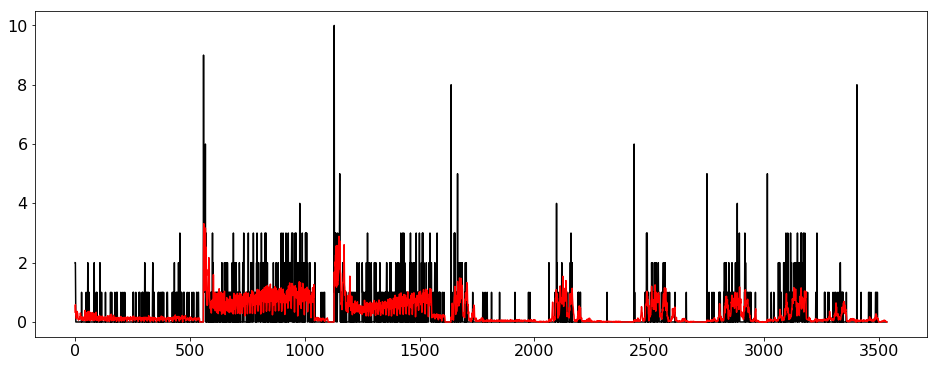

In [316]:

eb = 7
plt.figure(figsize=(16,6))
plt.plot(np.sum(analysis1.dataset.binned_data[:,eb,:,:].reshape(1,30*1145)[:,background1.calc_this[eb]].ravel().reshape(1,len(background1.calc_this[eb])),axis=0))
plt.plot(np.sum(np.median(result1.fit_pars[eb]['model_values'],axis=0).reshape(1,len(background1.calc_this[eb])),axis=0))

In [ ]:
73464/24

In [ ]:
np.median(result.fit_pars[4]['model_tot'],axis=0)/(analysis.dataset.times.times_wid*2)

In [ ]:
analysis.dataset.times.times_wid

In [ ]:
np.median(result.fit_pars[b]['flux'],axis=0)

In [ ]:
sky_data.dataset.binned_data.shape

In [ ]:
plt.plot(analysis.dataset.times.times_cen[::2],
         np.median(result.fit_pars[3]['Abg'],axis=0))

In [731]:
#data_dir = 'data'
#filename = 'test_dataset_9det_CE0000-1000keV_EHCstandard.tra.gz'
#filename = 'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'

#data_dir = '/Users/thomassiegert/data/COSI/Simulations/clio/from_cronus/'
#filename = 'CrabOnly_CE_0000-5000keV.tra'

#data_dir = '/Users/thomassiegert/data/COSI/Simulations/sources_with_atmosphere/Nova_OneHour_atmo/'
#filename = 'nova511_superstrong_CE0000-1000keV.tra.gz'

#data_dir = '/Users/thomassiegert/data/COSI/Simulations/Crab/ThomasSims/'
#filename = 'Crab_fixed.inc1.id1.extracted.tra'
#filename2 = 'Crab_fixed_other.inc1.id1.extracted.tra'
#filename3 = 'Crab_fixed_highzen.inc1.id1.extracted.tra'

#filename4 = 'Crab_fixed_12det.inc1.id1.extracted.tra'


data_dir = '/Users/thomassiegert/data/COSI/Simulations/Crab/'
filename1 = 'FlatSource_001_CE0000-5000keV.tra.gz'
filename2 = 'FlatSource_002_CE0000-5000keV.tra.gz'
filename3 = 'FlatSource_003_CE0000-5000keV.tra.gz'
filename1 = 'Crab_004_moving_CE0000-5000keV.tra.gz'#'Crab_001_CE0000-5000keV.tra.gz'
filename2 = 'Crab_002_CE0000-5000keV.tra.gz'
filename3 = 'Crab_003_CE0000-5000keV.tra.gz'

In [735]:
#energy_bin_edges=np.array([150,325,506,516,650])
energy_bin_edges=np.array([ 150,  220,  325,  480,  520,  765, 1120, 1650, 2350])#, 3450])#, 5000])
#energy_bin_edges=np.array([506,516])
#energy_bin_edges=np.arange(156,996,10)
#energy_bin_edges = np.logspace(2,3,7)
#energy_bin_edges = np.logspace(2,3,12)

In [ ]:
l2,b2 = 184.56-360,-30.00
l3,b3 = 184.56-360,-50.00

In [673]:
zens3,azis3 = response.zenazi(pointing3.xpoins[:,0],pointing3.xpoins[:,1],
                   pointing3.ypoins[:,0],pointing3.ypoins[:,1],
                   pointing3.zpoins[:,0],pointing3.zpoins[:,1],
                   l3,b3)

In [674]:
zens2,azis2 = response.zenazi(pointing2.xpoins[:,0],pointing2.xpoins[:,1],
                   pointing2.ypoins[:,0],pointing2.ypoins[:,1],
                   pointing2.zpoins[:,0],pointing2.zpoins[:,1],
                   l2,b2)

In [675]:
zens1,azis1 = response.zenazi(pointing1.xpoins[:,0],pointing1.xpoins[:,1],
                   pointing1.ypoins[:,0],pointing1.ypoins[:,1],
                   pointing1.zpoins[:,0],pointing1.zpoins[:,1],
                   l1,b1)

In [106]:
deg2rad = np.pi/180

In [677]:
zens1[0],zens2[0],zens3[0]

(7.357403417624611, 30.312653323792016, 50.152012287978636)

In [678]:
azis1[0]/6,azis2[0]/6,azis3[0]/6

(8.642202958166507, 13.693248868523568, 14.363899798166088)

In [107]:
domega1 = ((np.sin((zens1+6/2)*deg2rad)-np.sin((zens1-6/2)*deg2rad))*6*deg2rad)
#domega1 = np.sum(domega1*pointing1.dtpoins)/np.sum(pointing1.dtpoins)
#domega1

In [812]:
domega1 = np.abs((np.sin((zens1+6/2)*deg2rad)-np.sin((zens1-6/2)*deg2rad))*6*deg2rad)
domega1# = np.sum(domega1*pointing1.dtpoins)/np.sum(pointing1.dtpoins)

array([2.37832890e-03, 1.37554258e-03, 2.95779439e-04, 5.50631952e-04,
       1.04250074e-03, 1.96597491e-03, 2.24138694e-03, 2.35491698e-03,
       2.76260082e-03, 2.96934597e-03, 3.13163464e-03, 3.26320557e-03,
       3.37460960e-03, 3.55393455e-03, 3.61378523e-03, 3.77612752e-03,
       4.05393710e-03, 4.77316653e-03, 5.60009876e-03, 6.22114846e-03,
       6.66065189e-03, 7.39094576e-03, 7.61232248e-03, 7.95475462e-03,
       8.13821798e-03, 8.34312263e-03, 8.52396571e-03, 8.72871083e-03,
       9.26194860e-03, 9.43591457e-03, 9.59646928e-03, 9.85212787e-03,
       1.01255978e-02, 1.03285402e-02, 1.04055786e-02, 1.04258138e-02,
       1.04786218e-02, 1.04955660e-02, 1.05043718e-02, 1.05046574e-02,
       1.04882711e-02, 1.04461856e-02, 1.03465722e-02, 1.01391499e-02,
       4.27382728e-03, 3.40636072e-03, 3.32290893e-03, 2.90400321e-03,
       2.56416656e-03, 2.21388167e-03, 1.89372752e-03, 1.67346307e-03,
       1.38337869e-03, 8.22004315e-04, 1.06137942e-03, 1.62587845e-05,
      

In [813]:
np.mean(domega1)

0.006224589050624927

In [810]:
zens1

array([ 77.4684771 ,  82.79084396,  88.45373276,  92.87944038,
        95.45754276, 100.33232985, 101.79925953, 102.40618938,
       104.59791432, 105.71756993, 106.6007769 , 107.3197927 ,
       107.93080211, 108.91881609, 109.24985888, 110.15121146,
       111.70597838, 115.81453869, 120.7238758 , 124.58025251,
       127.42022584, 132.39837859, 133.98562341, 136.52862579,
       137.9410251 , 139.56562226, 141.04570678, 142.78075494,
       147.66920104, 149.4116506 , 151.10338107, 154.00299607,
       157.48298251, 160.43811959, 161.67870157, 162.01822435,
       162.93500407, 163.23945636, 163.39981848, 163.40504504,
       163.10772889, 162.36642079, 160.7216005 , 157.6686869 ,
       112.94855401, 108.10532857, 107.64698574, 105.36305353,
       103.52860705, 101.65242136,  99.94868932,  98.7817632 ,
        97.2504447 ,  85.69923355,  95.55668183,  90.08498692,
        83.92170644,  80.40377262,  79.15599925,  74.04243052,
        69.66057535,  65.25578777,  60.36820188,  56.46

In [814]:
domega1**(-1)

array([  420.46329254,   726.98585536,  3380.89761087,  1816.09511831,
         959.23193577,   508.65349152,   446.1523269 ,   424.64342018,
         361.97773985,   336.77449864,   319.32205267,   306.44713552,
         296.33057402,   281.37828255,   276.71816004,   264.82156531,
         246.67378265,   209.50452797,   178.56827932,   160.74202488,
         150.13545463,   135.30068178,   131.36595346,   125.71098017,
         122.87702324,   119.85919953,   117.31628613,   114.56445508,
         107.96864062,   105.97806846,   104.20499154,   101.50091566,
          98.75960148,    96.8191028 ,    96.10229634,    95.91577442,
          95.43239741,    95.27832971,    95.19845809,    95.19586969,
          95.34459875,    95.72872254,    96.65036742,    98.62759804,
         233.98231472,   293.56843913,   300.9411391 ,   344.35223598,
         389.99026604,   451.6953241 ,   528.05907344,   597.56323144,
         722.86786648,  1216.53862551,   942.17014215, 61505.21290101,
      

In [680]:
domega2 = ((np.sin((zens2+6/2)*deg2rad)-np.sin((zens2-6/2)*deg2rad))*6*deg2rad)[0]
domega2 = np.sum(domega2*pointing2.dtpoins)/np.sum(pointing2.dtpoins)
domega2

0.00946264448431293

In [681]:
domega3 = ((np.sin((zens3+6/2)*deg2rad)-np.sin((zens3-6/2)*deg2rad))*6*deg2rad)[0]
domega3 = np.sum(domega3*pointing3.dtpoins)/np.sum(pointing3.dtpoins)
domega3

0.0070234321104268565

In [682]:
tmp = np.sum(rsp.rsp.response_grid_normed[1,8,:,:,:,:],axis=(0,1))

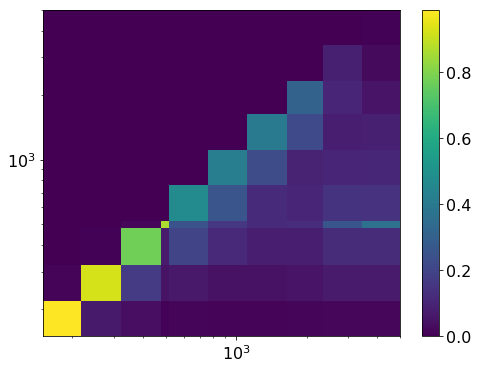

In [683]:
plt.pcolormesh(rsp.e_edges,rsp.e_edges,tmp.T/erg_mat[1]/np.sum(tmp.T/erg_mat[1],axis=0))
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [684]:
print(np.round(tmp.T/erg_mat[1]/np.sum(tmp.T/erg_mat[1],axis=0)*100))

[[99.  7.  4.  1.  1.  1.  1.  1.  2.  2.]
 [ 1. 93. 17.  5.  7.  5.  4.  5.  7.  7.]
 [ 0.  1. 77.  7. 20. 11.  8.  8. 12. 12.]
 [ 0.  0.  2. 87. 25. 16. 12. 13. 26. 37.]
 [ 0.  0.  0.  0. 47. 26. 12. 10. 15. 14.]
 [ 0.  0.  0.  0.  0. 42. 23.  9. 10. 11.]
 [ 0.  0.  0.  0.  0.  0. 40. 22.  8.  9.]
 [ 0.  0.  0.  0.  0.  0.  0. 31. 10.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  9.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [685]:
np.sum(tmp.T/erg_mat[0]/np.sum(tmp.T/erg_mat[0],axis=0),axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

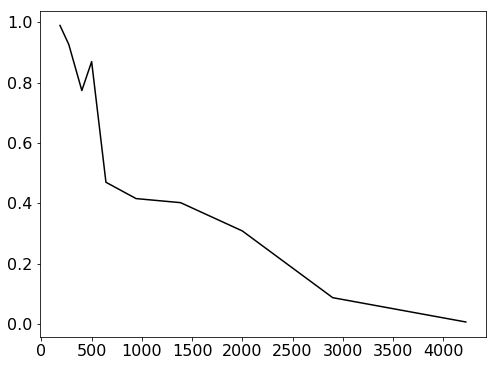

In [686]:
plt.plot(rsp.e_cen,np.diag(tmp.T/erg_mat[1]/np.sum(tmp.T/erg_mat[1],axis=0)))

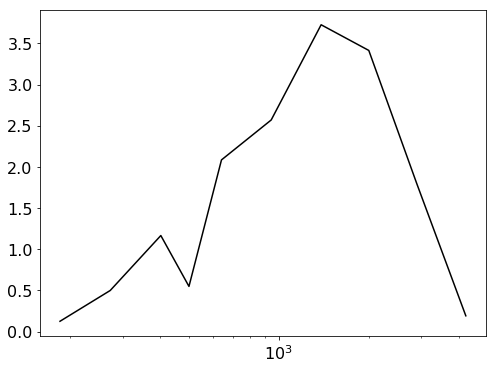

In [687]:
plt.plot(rsp.e_cen,np.dot((tmp.T/erg_mat[1]/np.sum(tmp.T/erg_mat[1],axis=0)),plaw_true_fluxes)*rsp.e_wid)
plt.xscale('log')

In [688]:
erg_mat = np.meshgrid(rsp.e_wid,rsp.e_wid)#np.diff(energy_bin_edges),np.diff(energy_bin_edges))

In [689]:
erg_mat[0],erg_mat[1]

(array([[  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550],
        [  70,  105,  155,   40,  245,  355,  530,  700, 1100, 1550]]),
 array([[  70,   70,   70,   70,   70,   70,   70,   70,   70,   70],
        [ 105,  105,  105,  105,  105,  105,  105,  105,  105,  105],
        [ 155,  155,  155,  155,  155,  155,  155,  155,  155,  155],
        [  40,   40,   40,   40,   40,   40,   40,   40,   40,   40],
        [ 245,  24

In [690]:
sky_filename1 = filename1#'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'
sky_data1 = COSIpy(data_dir,sky_filename1)
sky_data1.read_COSI_DataSet()
sky_data1.dataset.time_binning_tags(time_bin_size=1e5)
sky_data1.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                             pixel_size=6.)
sky_data1.dataset.get_binned_data()

In [691]:
sky_filename2 = filename2#'SRC9det_PS511keV_l-010_b-010_simOP_160628_FullDay_CE0000-1000keV_EHCstandard.tra.gz'
sky_data2 = COSIpy(data_dir,sky_filename2)
sky_data2.read_COSI_DataSet()
sky_data2.dataset.time_binning_tags(time_bin_size=1e5)
sky_data2.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                             pixel_size=6.)
sky_data2.dataset.get_binned_data()

In [692]:
sky_filename3 = filename3#'SRC9det_PS511keV_l-010_b-010_simOP_160638_FullDay_CE0000-1000keV_EHCstandard.tra.gz'
sky_data3 = COSIpy(data_dir,sky_filename3)
sky_data3.read_COSI_DataSet()
sky_data3.dataset.time_binning_tags(time_bin_size=1e5)
sky_data3.dataset.init_binning(energy_bin_edges=energy_bin_edges,
                             pixel_size=6.)
sky_data3.dataset.get_binned_data()

In [ ]:
params0 = [9.06e-4,   # power-law amplitude at 1000 keV in ph/cm2/s/keV
           -2.169]    # power-law index